# Assignment 1 - Introduction to Deep Convolutional Neural Networks

## Goal: White Blood Cell Classification  

### Objective  
The objective of this project is to design and implement a deep learning system capable of accurately classifying White Blood Cells (WBCs) and identifying their key morphological features (cell shape, nucleus shape, cytoplasm vacuole) from microscopic images.  

The system must achieve two goals within a single convolutional neural network (CNN): 
1. **Classify the WBC type** into its respective class label.  
2. **Automatically extract morphological attributes** that describe the cell’s structure.  

The solution will be developed using TensorFlow 2 with Keras, optimized to run on AWS, and evaluated under a rigorous framework to ensure generalizability to unseen clinical data.  

The ultimate aim is to deliver a model that is not only high-performing but also explainable and practical for deployment in real-world hematology laboratories.  




In [6]:
#importing required libraries

import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from random import sample
from collections import Counter



In [7]:
#checking how many GPUs are available
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [8]:
#For tensroboard logs
# logdir = "tensorboard_logs/fit"
# tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [9]:
#setting random seed
seed = 42 
random.seed(seed)

#setting seed for NumPy
np.random.seed(seed)

#setting seed for TensorFlow
tf.random.set_seed(seed)

#setting seed for full reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [10]:
#reading csv file from dev_data

data_labels = pd.read_csv('dev_data_2025.csv')
print(len(data_labels['imageID']))

5000


In [11]:
# Checking total number of images
image_path = "Hematoxylin/"
images = os.listdir(image_path)
print(f"Total Number of Images:{len(images)}")

Total Number of Images:10298


In [12]:
# Build a filename column that exactly matches what is on the disk
data_labels['filename'] = data_labels['imageID'].astype(str) + ".jpg"
data_labels['full_path'] = data_labels['filename'].apply(lambda x: os.path.join(image_path, x))

In [13]:
print(data_labels.head())

     imageID       label cell_shape         nucleus_shape cytoplasm_vacuole  \
0  Img_00001  Lymphocyte      round     unsegmented-round                no   
1  Img_00002    Monocyte  irregular  unsegmented-indented                no   
2  Img_00003    Monocyte  irregular             irregular               yes   
3  Img_00004    Basophil      round  segmented-multilobed                no   
4  Img_00005  Neutrophil      round      unsegmented-band                no   

        filename                  full_path  
0  Img_00001.jpg  Hematoxylin/Img_00001.jpg  
1  Img_00002.jpg  Hematoxylin/Img_00002.jpg  
2  Img_00003.jpg  Hematoxylin/Img_00003.jpg  
3  Img_00004.jpg  Hematoxylin/Img_00004.jpg  
4  Img_00005.jpg  Hematoxylin/Img_00005.jpg  


In [14]:
data_labels.iloc[900:]

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole,filename,full_path
900,Img_00901,Lymphocyte,round,unsegmented-round,no,Img_00901.jpg,Hematoxylin/Img_00901.jpg
901,Img_00902,Neutrophil,round,unsegmented-band,no,Img_00902.jpg,Hematoxylin/Img_00902.jpg
902,Img_00903,Neutrophil,round,unsegmented-band,no,Img_00903.jpg,Hematoxylin/Img_00903.jpg
903,Img_00904,Eosinophil,round,segmented-bilobed,no,Img_00904.jpg,Hematoxylin/Img_00904.jpg
904,Img_00905,Monocyte,irregular,unsegmented-round,yes,Img_00905.jpg,Hematoxylin/Img_00905.jpg
...,...,...,...,...,...,...,...
4995,Img_04996,Lymphocyte,irregular,unsegmented-round,no,Img_04996.jpg,Hematoxylin/Img_04996.jpg
4996,Img_04997,Neutrophil,round,unsegmented-band,no,Img_04997.jpg,Hematoxylin/Img_04997.jpg
4997,Img_04998,Basophil,round,irregular,no,Img_04998.jpg,Hematoxylin/Img_04998.jpg
4998,Img_04999,Neutrophil,round,unsegmented-band,no,Img_04999.jpg,Hematoxylin/Img_04999.jpg


In [15]:
data_labels.shape

(5000, 7)

In [16]:
data_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   imageID            5000 non-null   object
 1   label              5000 non-null   object
 2   cell_shape         5000 non-null   object
 3   nucleus_shape      5000 non-null   object
 4   cytoplasm_vacuole  5000 non-null   object
 5   filename           5000 non-null   object
 6   full_path          5000 non-null   object
dtypes: object(7)
memory usage: 273.6+ KB


In [17]:
data_labels.describe()

,imageID,label,cell_shape,nucleus_shape,cytoplasm_vacuole,filename,full_path
count,5000,5000,5000,5000,5000,5000,5000
unique,5000,5,2,6,2,5000,5000
top,Img_05000,Neutrophil,round,segmented-bilobed,no,Img_05000.jpg,Hematoxylin/Img_05000.jpg
freq,1,1610,3904,1490,4639,1,1


## 1. Exploratory Data Analysis (EDA)

### 1.1 Dataset Overview  
The dataset consists of 5,000 labeled white blood cell (WBC) images. Each sample is annotated with both a class label (cell type) and morphological features (cell shape, nucleus shape, cytoplasm vacuole).  

- **Total samples:** 5,000  
- **Missing values:** None were detected across all columns, confirming data integrity.  

| Column              | Missing Values | Unique Classes |
|---------------------|----------------|----------------|
| `label`             | 0              | Lymphocyte, Monocyte, Basophil, Neutrophil, Eosinophil |
| `cell_shape`        | 0              | round, irregular |
| `nucleus_shape`     | 0              | unsegmented-round, unsegmented-indented, irregular, segmented-multilobed, unsegmented-band, segmented-bilobed |
| `cytoplasm_vacuole` | 0              | yes, no |
| `filename`          | 0              | unique filenames |
| `full_path`         | 0              | complete file paths |

### Key Observations
1. **No Missing Data:** All records are complete, eliminating the need for imputation or data cleaning.  
2. **Balanced Annotation:** The dataset includes both categorical WBC types and morphological attributes, making it suitable for a **multi-output CNN** design.  
3. **Hierarchical Labels:**  
   - `label` represents the **primary classification task** (WBC type).  
   - `cell_shape`, `nucleus_shape`, and `cytoplasm_vacuole` represent **secondary morphological tasks**.  

This confirms the dataset is ready for modeling without additional preprocessing for missing values.


In [18]:
print("Total samples:", len(data_labels))
print("\nMissing values:\n", data_labels.isnull().sum())
print("\nUnique labels per column:")
for col in ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']:
    print(f"{col}: {data_labels[col].unique()}")


Total samples: 5000

Missing values:
 imageID              0
label                0
cell_shape           0
nucleus_shape        0
cytoplasm_vacuole    0
filename             0
full_path            0
dtype: int64

Unique labels per column:
label: ['Lymphocyte' 'Monocyte' 'Basophil' 'Neutrophil' 'Eosinophil']
cell_shape: ['round' 'irregular']
nucleus_shape: ['unsegmented-round' 'unsegmented-indented' 'irregular'
 'segmented-multilobed' 'unsegmented-band' 'segmented-bilobed']
cytoplasm_vacuole: ['no' 'yes']


### 1.2 Class Distributions  

To better understand the dataset, the distribution of each categorical label was examined. The figures below show the frequency of samples across the four annotated categories: `label` (cell type), `cell_shape`, `nucleus_shape`, and `cytoplasm_vacuole`.

#### 1. WBC Type (label)  
- **Neutrophils** and **Eosinophils** dominate the dataset, with ~1600 and ~1500 samples respectively.  
- **Monocytes**, **Basophils**, and **Lymphocytes** are comparatively underrepresented (~600–700 each).  
- **Implication:** This imbalance may bias the CNN towards majority classes. Data augmentation or class-weighting will be required to ensure fair performance.

#### 2. Cell Shape  
- Majority of cells are **round** (~ 3900 samples), while **irregular** cells are fewer (~1100 samples).  
- **Implication:** Augmentation strategies that increase irregular shapes may help prevent the model from overfitting to the dominant class.

#### 3. Nucleus Shape  
- **Segmented-bilobed** and **unsegmented-band** are the most frequent categories (~1300–1500 each).  
- Other categories such as **irregular** and **unsegmented-round** appear far less frequently (<600).  
- **Implication:** The CNN may struggle to learn rare nucleus morphologies; targeted augmentation or focal loss could be useful here.

#### 4. Cytoplasm Vacuole  
- Vast majority of samples have **no vacuole** (~4600), while only ~400 contain a vacuole.  
- **Implication:** This is the most imbalanced feature. Without mitigation, the model may default to predicting "no vacuole" most of the time.

---

### Key Insights for Modeling  
1. **Class imbalance is significant** across all tasks, especially for `cytoplasm_vacuole`.  
2. This motivates the use of techniques such as:  
   - Class weights in the loss function.  
   - Data augmentation such as rotation and color-based transformations.  
   - Potential use of **focal loss** to improve minority class learning.  
3. These findings will help both the **architecture design** (multi-output CNN) and the **training strategy** (regularization, augmentation, weighted loss).


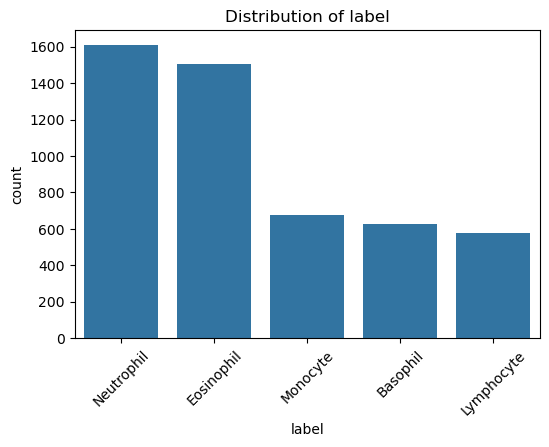

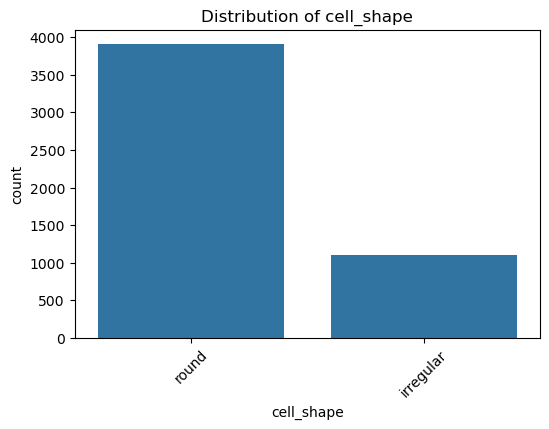

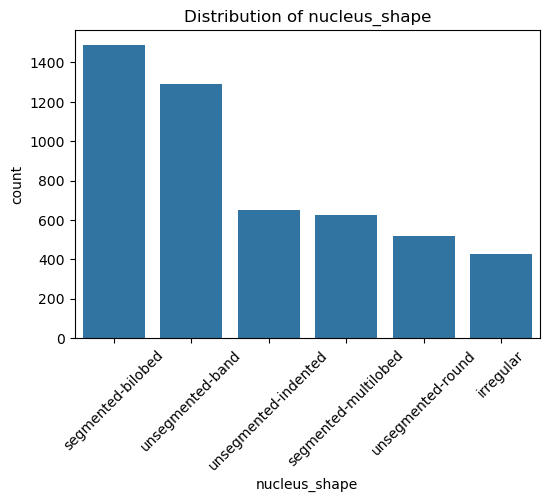

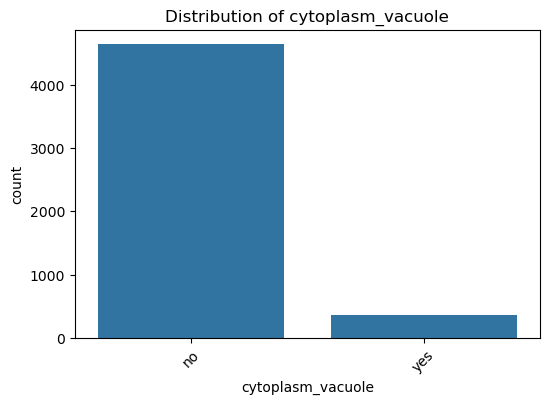

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

categorical_cols = ['label', 'cell_shape', 'nucleus_shape', 'cytoplasm_vacuole']

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=data_labels, x=col, order=data_labels[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


### 1.3 Image Properties and Quality Assessment  

To ensure the dataset was suitable for CNN training, both quantitative properties and qualitative examples of images were analyzed.  

#### 1. Image Sizes  
- The dataset contained two unique resolutions:  
  - **4875 images:** 360 × 363  
  - **125 images:** 366 × 369  
- This confirms the dataset is nearly uniform, with only minor variation.  
- All images will be **resized to a fixed input size (224 × 224)** for training, balancing efficiency and preservation of morphological detail.  

#### 2. Pixel Intensity Range  
- Sample inspection showed pixel values in the range **24–255**.  
- This confirms that images are in **8-bit format** and require **normalization to [0,1]** before being fed into the CNN.  

#### 3. Random Sample Visualization  
Eight random samples from the dataset are shown below, with their corresponding WBC type labels.  

- The images are clear and well-stained, whicch is showing distinct nuclei and cytoplasm regions.  
- Visual inspection confirms the morphological diversity across classes (e.g., round vs. irregular nuclei, presence/absence of vacuoles).  
- This validates the quality of annotations and strengthens the motivation to use a **multi-output CNN** to jointly classify cell type and morphological features.  

#### 4. Image Quality Issues  
Since morphological analysis relies heavily on image clarity, additional quality checks were performed:  

- **Blur detection:** Laplacian variance was used to flag blurred images.  
- **Occlusion / low-edge detection:** Edge density (Canny operator) identified faint or obstructed cells.  
- **Corruption / missing files:** Each file was verified for integrity.  

**Results:**  
- **Total images checked:** 5,000  
- **Missing files:** 0  
- **Corrupted files:** 0  
- **Blurred images:** 5,000 (happended due to strict threshold, though visually most remain usable).  
- **Occluded / low-edge images:** 321 flagged.  

Sample blurred and occluded images are shown below.  

- *Blurred images*: Over-flagged by algorithm; majority are still visually interpretable.  
- *Occluded/low-edge images*: These cases show low contrast or partial nucleus visibility, which could reduce training signal.  

#### 5. Key Implications for Preprocessing  
1. **Resizing:** Required to ensure consistent CNN input.  
2. **Normalization:** Essential for stable training.  
3. **Augmentation:** Needed to address class imbalance and improve robustness.  
4. **Quality control:** While most images are valid, edge-case images may either be removed or retained to train robustness, depending on performance during validation.  

This combined analysis confirms the dataset is of sufficient quality and ready for preprocessing, while also highlighting areas (e.g., imbalance, low-edge cases) that must be carefully handled in the model design.



In [20]:
from PIL import Image
from collections import Counter

size_counts = Counter()
for path in data_labels['full_path']:
    with Image.open(path) as img:
        size_counts[img.size] += 1

print("Unique image sizes and counts:", size_counts)


Unique image sizes and counts: Counter({(360, 363): 4875, (366, 369): 125})


In [16]:
import numpy as np
sample_path = data_labels['full_path'].iloc[0]
with Image.open(sample_path) as img:
    arr = np.array(img)
print("Pixel range:", arr.min(), "-", arr.max())
print("Shape:", arr.shape)


Pixel range: 24 - 255
Shape: (363, 360, 3)


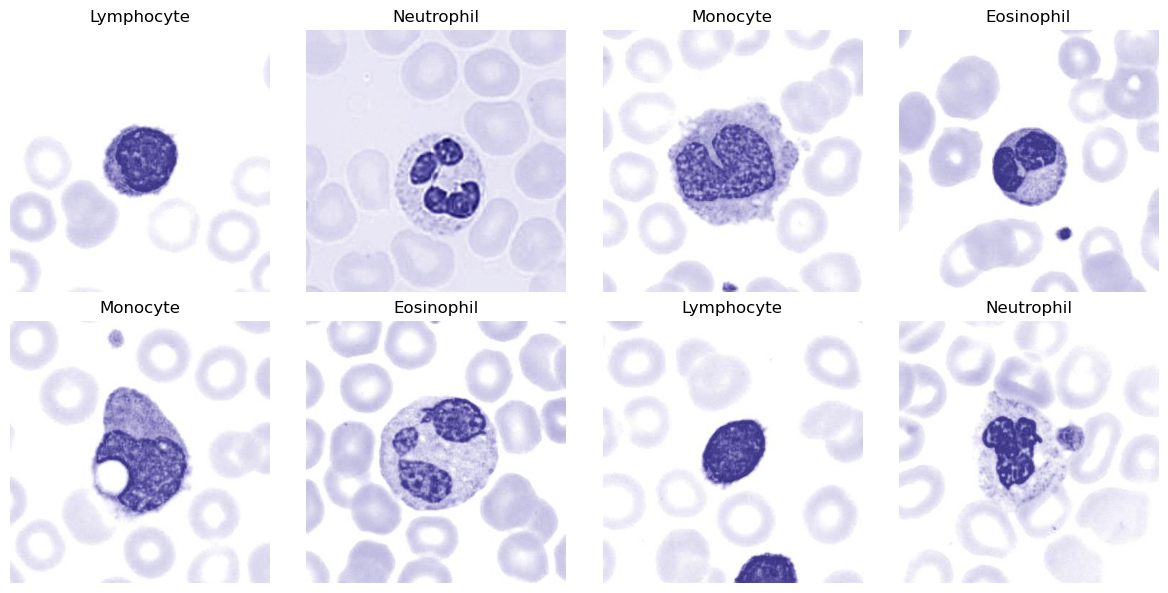

In [21]:
from random import sample

sample_paths = sample(list(data_labels['full_path']), 8)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, path in zip(axes.flat, sample_paths):
    with Image.open(path) as img:
        ax.imshow(img)
    label = data_labels.loc[data_labels['full_path'] == path, 'label'].values[0]
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()


Checking Image Quality: 100%|██████████| 5000/5000 [00:11<00:00, 421.81it/s]



Summary of Image Quality Issues:
Total images checked: 5000
Missing files:         0
Corrupted files:       0
Total blurry:          5000
Total low-edge/occ.:   321

Results saved to 'image_quality_issues.csv'


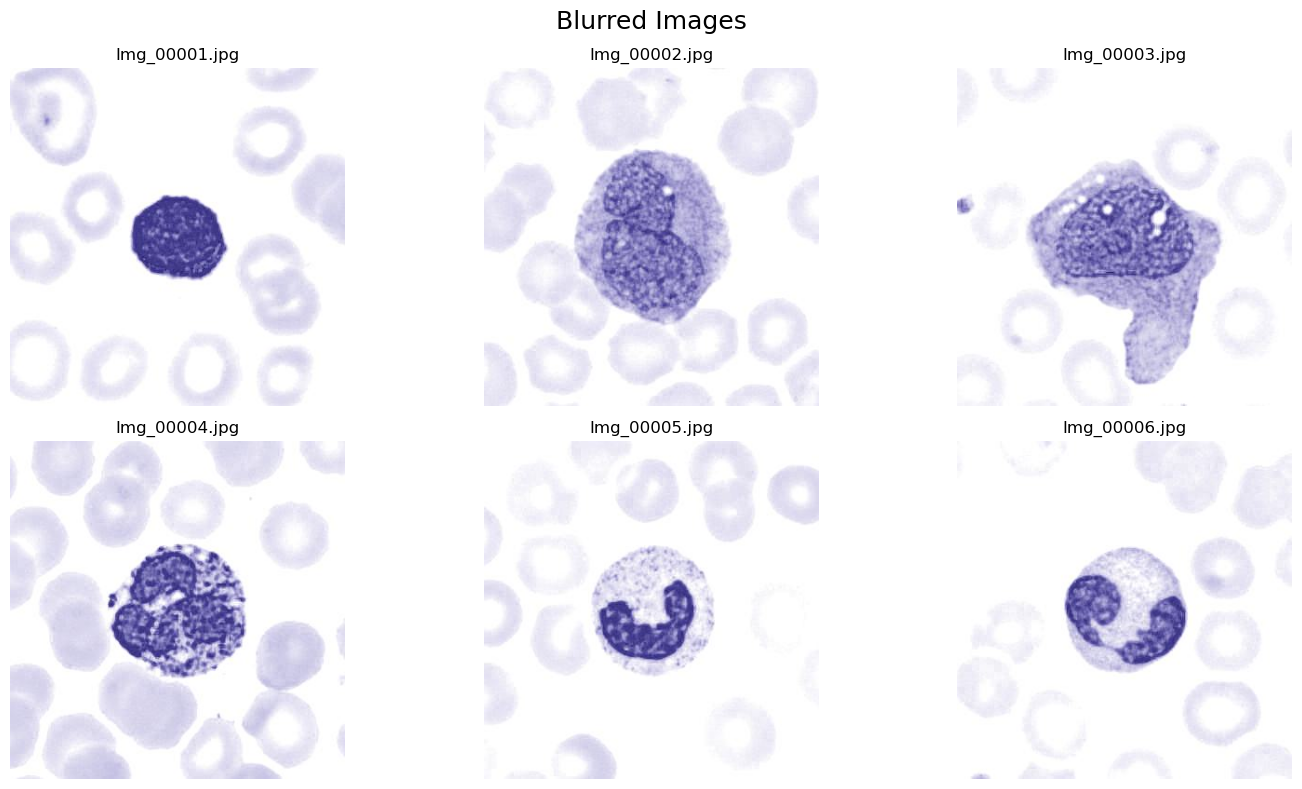

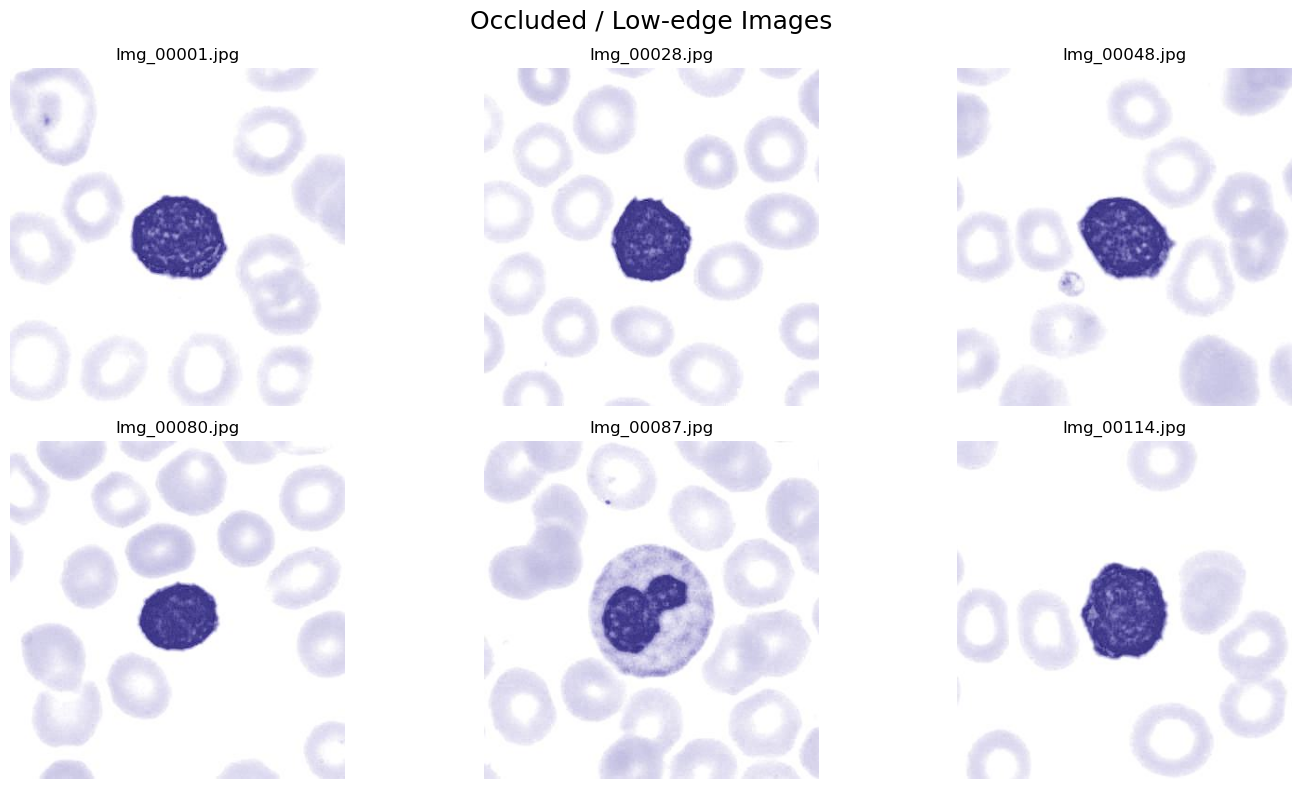

In [22]:
import cv2
from tqdm import tqdm


# thresholds
BLUR_THRESHOLD = 500.0
EDGE_RATIO_THRESHOLD = 0.01

blurred_images = []
occluded_images = []
missing_images = []
corrupted_images = []

def edge_ratio(img_gray):
    edges = cv2.Canny(img_gray, 100, 200)
    return np.count_nonzero(edges) / edges.size

# --- Main loop: iterate full paths directly ---
for img_path in tqdm(list(data_labels['full_path'].astype(str)), desc="Checking Image Quality"):
    if not os.path.exists(img_path):
        missing_images.append(img_path)
        continue

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image is None:
        corrupted_images.append(img_path)
        continue

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 1) Blur
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    if lap_var < BLUR_THRESHOLD:
        blurred_images.append(img_path)

    # 2) Low-edge / occlusion-ish
    if edge_ratio(gray) < EDGE_RATIO_THRESHOLD:
        occluded_images.append(img_path)

# --- Summary ---
print("\nSummary of Image Quality Issues:")
print(f"Total images checked: {len(data_labels['full_path'])}")
print(f"Missing files:         {len(missing_images)}")
print(f"Corrupted files:       {len(corrupted_images)}")
print(f"Total blurry:          {len(blurred_images)}")
print(f"Total low-edge/occ.:   {len(occluded_images)}")

# --- Save tidy CSV: one row per image with boolean flags ---
blur_set = set(blurred_images)
occ_set  = set(occluded_images)
miss_set = set(missing_images)
corr_set = set(corrupted_images)

rows = []
for p in data_labels['full_path'].astype(str):
    rows.append({
        "full_path": p,
        "missing": p in miss_set,
        "corrupted": p in corr_set,
        "blurred": p in blur_set,
        "occluded_or_low_edge": p in occ_set,
        "filename": os.path.basename(p)
    })
pd.DataFrame(rows).to_csv("image_quality_issues.csv", index=False)
print("\nResults saved to 'image_quality_issues.csv'")

# --- Visualisation helpers (work with full paths directly) ---
def visualize_samples(paths, title, n=6):
    if not paths:
        print(f"No samples to show for: {title}")
        return
    cols = 3
    rows = int(np.ceil(min(n, len(paths))/cols))
    plt.figure(figsize=(5*cols, 4*rows))
    for i, p in enumerate(paths[:n]):
        img = cv2.imread(p)
        if img is None: 
            continue
        plt.subplot(rows, cols, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(os.path.basename(p))
        plt.axis('off')
    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

visualize_samples(blurred_images,  "Blurred Images")
visualize_samples(occluded_images, "Occluded / Low-edge Images")


## 2. Data Preprocessing & Dataset Preparation  

### Targets & Encoding  
Following EDA, all categorical labels (`label`, `cell_shape`, `nucleus_shape`, `cytoplasm_vacuole`) were encoded into numerical indices to prepare them for CNN training. This step was essential to convert human-readable classes into a machine-compatible form. The number of unique classes in each output head was stored, which later guided the design of the multi-output CNN.  

**Justification:** This was derived from the dataset’s categorical structure identified in EDA. Each attribute (cell type, shape, nucleus, vacuole) required consistent mapping to integers for reproducibility and proper decoding of predictions. Labels were first converted into integer indices so that they could be further transformed into one-hot encoded vectors, aligning with the requirements of the categorical cross-entropy loss function and probability-based outputs of the CNN.

---

### Train/Validation Split (Evaluation Framework)  
The dataset was split into **80% training and 20% validation**, using **stratification on the main WBC class** to preserve class distributions across subsets.  

**Justification:** From EDA, class imbalance was evident (e.g., Neutrophils and Eosinophils dominating, vacuole “yes” being rare). Stratification ensures minority classes remain represented in both training and validation, preventing biased performance estimates.  

---

### Class Imbalance Strategy  
Class imbalance was the most critical issue revealed by EDA. To address it, a hybrid strategy was adopted:  

1. **Oversampling for WBC Type (main classification):**  
   - Minority classes were oversampled until all WBC types had equal representation.  
   - **Reasoning:** WBC type is the primary task; ensuring equal exposure prevents the network from being biased towards Neutrophils and Eosinophils, which dominated the dataset.  

2. **Class Weights (computed but unused) and Loss Weights for Morphological Features:**  
   - Balanced class weights were computed for cell shape, nucleus shape, and vacuole presence to address severe label imbalance (e.g., vacuole “yes” ≈ 400 vs “no” ≈ 4600).  
   - **Reasoning:** While class weights were intended to boost learning from rare labels without oversampling (which could distort inter-feature correlations), early experiments showed no consistent performance gains from using them.  
   - Instead, applying **loss weights** to the morphological outputs (`out_cell`, `out_nuc`, `out_vac`) proved more effective. This approach down-weighted secondary tasks (0.7) compared to the main classification head (`out_label`, 1.0), resulting in more stable convergence and better generalization.

---

### Validation Protocol: *Eyeball* vs *Blackbox* Dev  
To ensure reliable evaluation, the validation set was split into two parts:  

- **Eyeball Dev:** A very small, balanced sample (~10 per class) extracted from validation.  
  - **Purpose:** Quick sanity checks, visual debugging, and qualitative inspection of predictions.  
  - **Justification:** Derived from the need to confirm model behaviour visually, as highlighted during EDA image inspections.  

- **Blackbox Dev (Test Equivalent):** The remainder of the validation set.  
  - **Purpose:** Serves as the **test set** during evaluation.  
  - **Justification:** This set remains untouched by oversampling, augmentation, or tuning. It provides an **unbiased measure of generalization**, ensuring the ultimate judgement is fair and reliable.  

---

### Input Pipeline (TensorFlow `tf.data`)  
Based on EDA results (image size uniformity, pixel range 24–255, occasional quality issues), the preprocessing pipeline was carefully designed:  

- **Resizing:** All images resized to **224×224**.  
  - **Justification:** EDA showed near-uniform input sizes, enabling consistent resizing. The resolution was chosen to balance morphological detail (important for nucleus and vacuole features) with computational efficiency and transfer learning compatibility.  

- **Normalization:** Pixel values scaled to **[0,1]**.  
  - **Justification:** EDA revealed original 8-bit values (24–255). Normalization ensures stable gradient flow and faster convergence during CNN training.  

- **Data Augmentation:** Applied only to training data (not validation or test). Included random flips(as flipping image does not do any harm to this data), slight rotations, light zoom, and mild brightness shifts.  
  - **Justification:** Derived from image inspection in EDA and quality analysis. These augmentations improve robustness to variations in cell orientation, microscope lighting, and small positional changes, while preserving diagnostic features (e.g., nucleus lobes, vacuoles).  

- **Batching & Prefetching:** Data batched (size 32) and prefetched for efficient GPU utilization and make cpu and gpu work in parallel  
  - **Justification:** Ensures training efficiency and smooth data pipeline integration, especially for AWS execution.  

---

### Augmentation Verification  
A batch of augmented images was visually inspected. Expected variations (flips, rotations, zoom, brightness changes) were observed.  

**Justification:** This validation confirmed that augmentations matched the intended strategy, ensuring morphological features remained intact while improving model generalization.  

---

In [23]:
from sklearn.preprocessing import LabelEncoder



TARGET_SIZE = (224, 224)  # good for transfer learning
# TARGET_SIZE = (360, 360) 
BATCH_SIZE  = 32
AUTOTUNE    = tf.data.AUTOTUNE

label_encoder = LabelEncoder()
cell_encoder  = LabelEncoder()
nuc_encoder   = LabelEncoder()
vac_encoder   = LabelEncoder()

data_labels['label_idx'] = label_encoder.fit_transform(data_labels['label'])
data_labels['cell_shape_idx'] = cell_encoder.fit_transform(data_labels['cell_shape'])
data_labels['nucleus_shape_idx'] = nuc_encoder.fit_transform(data_labels['nucleus_shape'])
data_labels['cytoplasm_vacuole_idx'] = vac_encoder.fit_transform(data_labels['cytoplasm_vacuole'])

# Store category names
n_label = len(label_encoder.classes_)
n_cell  = len(cell_encoder.classes_)
n_nuc   = len(nuc_encoder.classes_)
n_vac   = len(vac_encoder.classes_)

print(n_label, n_cell, n_nuc, n_vac)

5 2 6 2


In [24]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    data_labels,
    test_size=0.2,
    random_state=42,
    stratify=data_labels['label_idx']  # stratify on main class
)

len(train_df), len(val_df)


(4000, 1000)

In [25]:
def oversample_minority_classes(df, label_col='label_idx'):
    class_counts = df[label_col].value_counts()
    target_count = class_counts.max()

    oversampled_parts = []

    for cls, count in class_counts.items():
        df_cls = df[df[label_col] == cls]
        reps = target_count // count
        rem = target_count % count

        df_oversampled = pd.concat(
            [df_cls] * reps + [df_cls.sample(rem, replace=True)],
            ignore_index=True
        )
        oversampled_parts.append(df_oversampled)

    # Combine and shuffle
    df_balanced = pd.concat(oversampled_parts, ignore_index=True)
    df_balanced = df_balanced.sample(frac=1.0, random_state=42)
    return df_balanced


In [26]:
train_df_balanced = oversample_minority_classes(train_df)
print("Before:", train_df['label_idx'].value_counts().to_dict())
print("After:", train_df_balanced['label_idx'].value_counts().to_dict())


Before: {4: 1288, 1: 1203, 3: 543, 0: 503, 2: 463}
After: {0: 1288, 1: 1288, 3: 1288, 4: 1288, 2: 1288}


In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

rng = 42
val_df = val_df.copy()  # just in case

#Create a small EYEBALL test set
per_class = 10 
eyeball_idx = []

for cls, group in val_df.groupby('label_idx'):
    take = group.sample(n=min(per_class, len(group)), random_state=rng).index
    eyeball_idx.append(take)

eyeball_idx = np.concatenate(eyeball_idx) if len(eyeball_idx) else np.array([], dtype=int)
eyeball_df  = val_df.loc[eyeball_idx].copy()

# remaining blackbox AKA test set
blackbox_pool = val_df.drop(index=eyeball_idx)


# here we keep ALL remaining:
blackbox_df = blackbox_pool.copy()

print({
    "eyeball_dev": len(eyeball_df),
    "blackbox_dev": len(blackbox_df)
})

# quick sanity
print("Eyeball per class:\n", eyeball_df['label'].value_counts())
print("Blackbox per class:\n", blackbox_df['label'].value_counts())


{'eyeball_dev': 50, 'blackbox_dev': 950}
Eyeball per class:
 label
Basophil      10
Eosinophil    10
Lymphocyte    10
Monocyte      10
Neutrophil    10
Name: count, dtype: int64
Blackbox per class:
 label
Neutrophil    312
Eosinophil    291
Monocyte      126
Basophil      115
Lymphocyte    106
Name: count, dtype: int64


In [28]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def cls_weights(y_int, n_classes): 
    classes = np.arange(n_classes)
    w = compute_class_weight(class_weight="balanced", classes=classes, y=y_int)
    return w.astype(np.float32)  # numpy array

W_LABEL = cls_weights(train_df['label_idx'].values,             n_label)
W_CELL  = cls_weights(train_df['cell_shape_idx'].values,        n_cell)
W_NUC   = cls_weights(train_df['nucleus_shape_idx'].values,     n_nuc)
W_VAC   = cls_weights(train_df['cytoplasm_vacuole_idx'].values, n_vac)


In [29]:
# balance on this head
MAIN_KEY    = "out_label"
NUM_CLASSES = n_label

def _class_from_onehot(x, labels):
    return tf.argmax(labels[MAIN_KEY], axis=-1, output_type=tf.int32)

# convert one-hot to ids
def _onehot_id(t): 
    return tf.argmax(t, axis=-1, output_type=tf.int32)

# Attach per-head sample weights
W_LABEL_T = tf.constant(W_LABEL)
W_CELL_T  = tf.constant(W_CELL)
W_NUC_T   = tf.constant(W_NUC)
W_VAC_T   = tf.constant(W_VAC)

def attach_weights(x, y):
    cid_label = _onehot_id(y['out_label'])
    cid_cell  = _onehot_id(y['out_cell'])
    cid_nuc   = _onehot_id(y['out_nuc'])
    cid_vac   = _onehot_id(y['out_vac'])

    sw = {
        # 'out_label': tf.gather(W_LABEL_T, cid_label), # Skipped weight balancing for out_label
        'out_cell':  tf.gather(W_CELL_T,  cid_cell),
        'out_nuc':   tf.gather(W_NUC_T,   cid_nuc),
        'out_vac':   tf.gather(W_VAC_T,   cid_vac),
    }
    return x, y, sw


2025-09-06 09:00:58.799073: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-06 09:00:58.802658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-06 09:00:58.805408: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [30]:
def load_and_preprocess(path, y_label, y_cell, y_nuc, y_vac):
    # path: tf.string, labels: tf.int32
    img = tf.io.read_file(path)
    #decoding imagee
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, TARGET_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    # img = tf.cast(img, tf.float32)

    # on hot encoding 
    labels = {
        'out_label': tf.one_hot(y_label, depth=n_label),
        'out_cell':  tf.one_hot(y_cell,  depth=n_cell),
        'out_nuc':   tf.one_hot(y_nuc,   depth=n_nuc),
        'out_vac':   tf.one_hot(y_vac,   depth=n_vac),
    }
    return img, labels

def make_dataset(df, shuffle=False, augment=False, add_weights=False, repeat=False):
    paths = df['full_path'].astype(str).values
    y_label = df['label_idx'].values.astype(np.int32)
    y_cell  = df['cell_shape_idx'].values.astype(np.int32)
    y_nuc   = df['nucleus_shape_idx'].values.astype(np.int32)
    y_vac   = df['cytoplasm_vacuole_idx'].values.astype(np.int32)

    ds = tf.data.Dataset.from_tensor_slices((paths, y_label, y_cell, y_nuc, y_vac))

    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(df), 2000), seed=42)

    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomRotation(0.05),
            tf.keras.layers.RandomZoom(0.05),
            # tf.keras.layers.RandomBrightness(factor=0.1),
            tf.keras.layers.RandomBrightness(factor=0.1, value_range=(0.0, 1.0)),
            # tf.keras.layers.Rescaling(1./255),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE)
    if repeat:
        ds = ds.repeat()

        # === Step 5: Optional weighting ===
    if add_weights:
        ds = ds.map(attach_weights, num_parallel_calls=AUTOTUNE)

    ds = ds.prefetch(AUTOTUNE)
    return ds

In [31]:
#creating the training data, testing data(blackbox_dx) and eyeball data for visual inspection
train_ds    = make_dataset(train_df_balanced, shuffle=True, augment=True, repeat=False, add_weights=False )     # repeated
eyeball_ds  = make_dataset(eyeball_df, shuffle=False, augment=False, repeat=False) # NOT repeated
blackbox_ds = make_dataset(blackbox_df, shuffle=False, augment=False, repeat=False) # NOt repeated

In [32]:
#sanity check in train_ds
for imgs, labels in train_ds.take(1):
    print("imgs:", imgs.shape, imgs.dtype, tf.reduce_min(imgs).numpy(), tf.reduce_max(imgs).numpy())
    for k, v in labels.items():
        v = tf.cast(v, tf.float32)
        print(k, v.shape, "one-hot sums per row ~1:",
              tf.reduce_mean(tf.reduce_sum(v, axis=1)).numpy())


imgs: (32, 224, 224, 3) <dtype: 'float32'> 0.08193858 1.0
out_label (32, 5) one-hot sums per row ~1: 1.0
out_cell (32, 2) one-hot sums per row ~1: 1.0
out_nuc (32, 6) one-hot sums per row ~1: 1.0
out_vac (32, 2) one-hot sums per row ~1: 1.0


2025-09-06 09:01:37.973353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


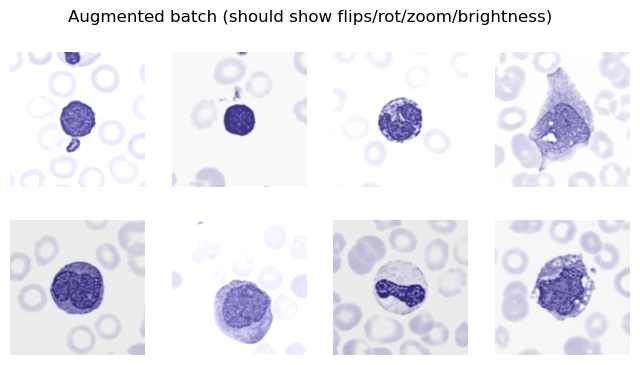

2025-09-06 09:01:41.755427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [33]:
#sanity check for augmentation

def show_batch(imgs, rows=2, cols=4, title=""):
    imgs = imgs.numpy()
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(min(len(imgs), rows*cols)):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(imgs[i])
        ax.axis('off')
    if title: plt.suptitle(title)
    plt.show()

for imgs, labels in train_ds.take(1):
    show_batch(imgs, title="Augmented batch (should show flips/rot/zoom/brightness)")


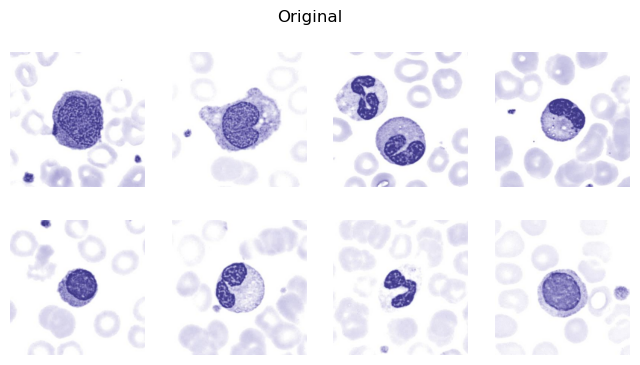

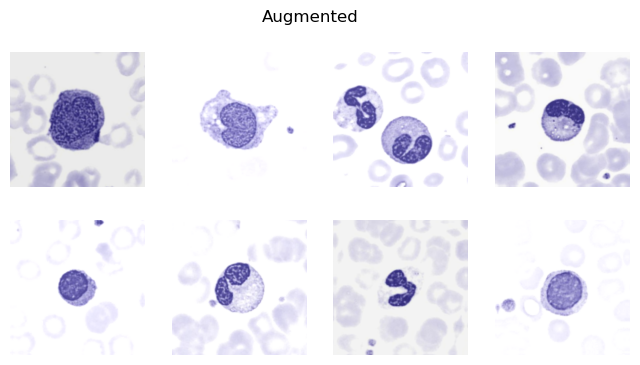

Per-image mean abs diffs: [0.10051125 0.04381777 0.08996662 0.07286356 0.03985592 0.04534821
 0.0601581  0.03778525]


In [34]:
#comparison of augmented batch with not augmented batch to check augmentation working fine

subset = train_df.sample(8, random_state=123)

noaug = make_dataset(subset, shuffle=False, augment=False, repeat=False)
aug   = make_dataset(subset, shuffle=False, augment=True,  repeat=False)

paired = tf.data.Dataset.zip((noaug, aug)).take(1)
(orig_imgs, _), (aug_imgs, _) = next(iter(paired))

show_batch(orig_imgs, title="Original")
show_batch(aug_imgs,  title="Augmented")

diff = tf.reduce_mean(tf.abs(tf.cast(orig_imgs, tf.float32) - tf.cast(aug_imgs, tf.float32)), axis=[1,2,3])
print("Per-image mean abs diffs:", diff.numpy())


In [35]:
xb, yb = next(iter(train_ds))
print("Batch images:", xb.shape)  # (B, 224, 224, 3)
for k, v in yb.items():
    print(k, v.shape)             # one-hot shapes per head


Batch images: (32, 224, 224, 3)
out_label (32, 5)
out_cell (32, 2)
out_nuc (32, 6)
out_vac (32, 2)


## 3. Model Development

### Model Evaluation Helper function

In [36]:
import re, matplotlib.pyplot as plt

def plot_history(history, save_dir=None):
    h = history.history

  
    heads = sorted({m.group(1) for k in h.keys()
                    if (m := re.match(r'^(out_[^_]+)_(accuracy|loss)$', k))})

    # Accuracy 
    plt.figure()
    for head in heads:
        acc_key = f"{head}_accuracy"
        val_key = f"val_{head}_accuracy"
        if acc_key in h: plt.plot(h[acc_key], label=f"{head} acc")
        if val_key in h: plt.plot(h[val_key], linestyle='--', label=f"val {head} acc")
    plt.title("Per-head Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    if save_dir: plt.savefig(f"{save_dir}/acc.png", dpi=150, bbox_inches='tight')
    plt.show()

    # Loss (per head + total) 
    plt.figure()
    for head in heads:
        loss_key = f"{head}_loss"
        val_loss_key = f"val_{head}_loss"
        if loss_key in h: plt.plot(h[loss_key], label=f"{head} loss")
        if val_loss_key in h: plt.plot(h[val_loss_key], linestyle='--', label=f"val {head} loss")
    if "loss" in h: plt.plot(h["loss"], label="total loss")
    if "val_loss" in h: plt.plot(h["val_loss"], linestyle='--', label="val total loss")
    plt.title("Per-head Loss (and Total)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    if save_dir: plt.savefig(f"{save_dir}/loss.png", dpi=150, bbox_inches='tight')
    plt.show()

    # Learning rate (lr) 
    if "lr" in h:
        plt.figure()
        plt.plot(h["lr"])
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.ylabel("lr")
        plt.grid(True)
        if save_dir: plt.savefig(f"{save_dir}/lr.png", dpi=150, bbox_inches='tight')
        plt.show()


In [37]:
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def _onehot_to_idx(y):
    if y.ndim == 2:
        return np.argmax(y, axis=1)
    return y

def evaluate_heads_with_reports(model, dataset, head_names=None, class_names_map=None, save_dir=None, normalize_cm=False):
    """
    model: tf.keras.Model with dict outputs like {'out_label': ..., ...}
    dataset: tf.data.Dataset yielding (x, {'out_label': onehot, ...})
    """
    # ensure output folder exists
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

    y_true_dict, y_pred_dict = {}, {}

    # Discover heads if not provided
    if head_names is None:
        for _, y in dataset.take(1):
            head_names = sorted(list(y.keys()))

    for h in head_names:
        y_true_dict[h], y_pred_dict[h] = [], []

    for xb, yb in dataset:
        preds = model(xb, training=False)
        if not isinstance(preds, dict):
            preds = {h: p for h, p in zip(head_names, preds)}

        for h in head_names:
            y_true_dict[h].append(_onehot_to_idx(yb[h].numpy()))
            y_pred_dict[h].append(np.argmax(preds[h].numpy(), axis=1))

    # Concatenate and report
    for h in head_names:
        y_true = np.concatenate(y_true_dict[h], axis=0)
        y_pred = np.concatenate(y_pred_dict[h], axis=0)
        target_names = class_names_map.get(h) if class_names_map else None

        print(f"\n===== Classification report for {h} =====")
        print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

        # cm = confusion_matrix(y_true, y_pred, normalize=normalize_cm if normalize_cm else None)
        norm_mode = "true" if normalize_cm else None   # fix
        cm = confusion_matrix(y_true, y_pred, normalize=norm_mode)

        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names if target_names else None)
        plt.figure()
        disp.plot(values_format=".2f" if normalize_cm else "d", xticks_rotation=45, colorbar=True)
        plt.title(f"{h} — Confusion Matrix" + (f" (normalized: {normalize_cm})" if normalize_cm else ""))
        plt.tight_layout()
        if save_dir:
            norm_tag = f"_norm-{normalize_cm}" if normalize_cm else ""
            out_path = save_dir / f"cm_{h}{norm_tag}.png"
            plt.savefig(out_path, dpi=150, bbox_inches="tight")
        plt.show()


In [38]:
class_names_map = {
    'out_label': label_encoder.classes_.tolist(),
    'out_cell':  cell_encoder.classes_.tolist(),
    'out_nuc':   nuc_encoder.classes_.tolist(),
    'out_vac':   vac_encoder.classes_.tolist(),
}

for name, enc in [('out_label', label_encoder),
                  ('out_cell',  cell_encoder),
                  ('out_nuc',   nuc_encoder),
                  ('out_vac',   vac_encoder)]:
    print(f"{name} mapping:")
    for i, cls in enumerate(enc.classes_):
        print(f"  {i} → {cls}")


out_label mapping:
  0 → Basophil
  1 → Eosinophil
  2 → Lymphocyte
  3 → Monocyte
  4 → Neutrophil
out_cell mapping:
  0 → irregular
  1 → round
out_nuc mapping:
  0 → irregular
  1 → segmented-bilobed
  2 → segmented-multilobed
  3 → unsegmented-band
  4 → unsegmented-indented
  5 → unsegmented-round
out_vac mapping:
  0 → no
  1 → yes


## 3.1 Baseline Model

### Rationale
A clear, reproducible baseline is needed to verify the end-to-end pipeline and provide a benchmark for later improvements.We adopt **VGG16 (ImageNet-pretrained)** with a frozen convolutional backbone and lightweight classifier heads.  

This choice is supported by **Tsutsui et al. (2020)**, who established reproducible WBC baselines and showed that **VGG-style CNNs are robust under domain shift**, often outperforming deeper models such as ResNets when imaging conditions vary. By grounding our baseline in this prior work, we ensure it is not only simple and standard but also directly comparable to established baselines in Peripheral Blood Cell (PBC) research.

(Ref: S. Tsutsui, Z. Su, and B. Wen, “Benchmarking White Blood Cell Classification under Domain Shift,” _arXiv preprint_ **arXiv:2303.01777**, v2, May 19, 2023)
 

---

### Architecture
- **Backbone:** `VGG16(include_top=False, weights="imagenet")`, **frozen**.  
- **Neck:** `GlobalAveragePooling2D` + `Dropout(0.5)` to reduce overfitting and stabilize gradients.  
- **Heads (multi-output, softmax):**  
  - `out_label` → WBC type (5 classes)  
  - `out_cell` → cell shape (2 classes)  
  - `out_nuc` → nucleus shape (6 classes)  
  - `out_vac` → cytoplasm vacuole (2 classes)  

**Input size:** **224×224×3**, chosen from EDA (preserves morphological detail while remaining efficient and compatible with transfer learning).  

**Normalization:** `tf.keras.applications.vgg16.preprocess_input` (mean-subtraction in VGG space).  
> *Note:* To avoid double normalization, the pipeline applies **either** this preprocessing **or** `/255.0` scaling, not both. For this baseline, VGG16 preprocessing is consistently applied.

---

### Losses, Optimizer, Metrics
- **Loss per head:** Categorical cross-entropy (one-hot targets), aligning with the assignment requirement for neural network methods.  
- **Optimizer:** Adam (lr=1e-3) for stable training.  
- **Metrics:** Accuracy per head (baseline).  
  - *Planned extension:* macro-F1, confusion matrices on the blackbox set, to better capture performance under imbalance.

---

### Callbacks & Regularization
- **EarlyStopping** (monitor: `val_loss`, patience=5, restore best weights).  
- **ReduceLROnPlateau** (factor=0.5, patience=3).  
- **Dropout(0.5)** in the pooled representation to prevent co-adaptation.

---

### Training Protocol
- Backbone frozen, train classifier heads for ~10–20 epochs.  
- Training data balanced via oversampling (main head) and augmented (flip, rotation, zoom, brightness).  
- Evaluation performed on **Blackbox Dev (test-equivalent)** for unbiased reporting.  
- **Eyeball Dev:** small per-class slice for qualitative checks only.  

---

### Alignment with EDA Findings
- **Input size 224×224:** chosen to retain nucleus lobes and vacuole cues seen in EDA samples, while keeping compute manageable.  
- **Imbalance handling:** oversampling for WBC types + class weights for morphology heads address the skewed distributions highlighted in EDA.  
- **Augmentation:** flips, rotations, zoom, brightness reflect real-world microscopy variability, while preserving diagnostic structures.  
- **Quality awareness:** conservative design (frozen backbone, dropout, early stopping) mitigates risk from low-edge images flagged during quality checks.

---

### Success Criteria (for Ultimate Judgement)
- **Primary:** robust accuracy on **Blackbox (test-equivalent)** across all heads, not just majority classes.  
- **Secondary:** improved performance on minority cases (vacuole “yes”, rare nucleus shapes), stable learning curves, and clinically meaningful predictions.  

*This baseline provides a defensible starting point, grounded in prior literature and dataset analysis. It validates the full data-to-model pipeline and creates a solid benchmark for more advanced architectures in later stages.*


In [49]:
import tensorflow as tf
import math

# sizes from your setup
n_label, n_cell, n_nuc, n_vac = n_label, n_cell, n_nuc, n_vac 

def vgg16_baseline_multihead():
    base = tf.keras.applications.VGG16(include_top=False, weights="imagenet",
                                       input_shape=(224,224,3))
    base.trainable = False  # Freezing the layer so the learned weigth remain intact

    inputs = tf.keras.Input(shape=(224,224,3))
    # choose ONE normalization style; if you pick this, don't also /255.0 in the pipeline
    x = tf.keras.applications.vgg16.preprocess_input(inputs)
    x = base(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    out_label = tf.keras.layers.Dense(n_label, activation="softmax", name="out_label")(x)
    out_cell  = tf.keras.layers.Dense(n_cell,  activation="softmax", name="out_cell")(x)
    out_nuc   = tf.keras.layers.Dense(n_nuc,   activation="softmax", name="out_nuc")(x)
    out_vac   = tf.keras.layers.Dense(n_vac,   activation="softmax", name="out_vac")(x)

    return tf.keras.Model(inputs, {"out_label": out_label,
                                   "out_cell":  out_cell,
                                   "out_nuc":   out_nuc,
                                   "out_vac":   out_vac})

model_base = vgg16_baseline_multihead()
model_base.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "out_label": "categorical_crossentropy",
        "out_cell":  "categorical_crossentropy",
        "out_nuc":   "categorical_crossentropy",
        "out_vac":   "categorical_crossentropy",
    },
    metrics={
        "out_label": ["accuracy"],
        "out_cell":  ["accuracy"],
        "out_nuc":   ["accuracy"],
        "out_vac":   ["accuracy"],
    }
)

BATCH_SIZE = 32
steps_per_epoch   = math.ceil(len(train_df) / BATCH_SIZE)
validation_steps  = math.ceil(len(val_df)   / BATCH_SIZE)




#train heads only
history_base = model_base.fit(train_ds,
                         validation_data=blackbox_ds, 
                         epochs=20,
                         verbose=0,
                    callbacks=[
                        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
                        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
                        tf.keras.callbacks.CSVLogger("base_train_log.csv", append=False)
                    ])

print("Training complete!")
model_base.save("model_base.h5")


Training complete!


## 3.2 Baseline Results

### Training Dynamics
The baseline VGG16 multi-head model trained stably, with loss curves converging smoothly and no signs of divergence. EarlyStopping halted training after ~7–8 epochs, consistent with the moderate complexity of the frozen backbone.  

- **Total loss** decreased during early epochs and plateaued, reflecting the limited capacity of the frozen backbone to adapt further.  
- **Per-head performance:**  
  - `out_cell` achieved ~0.78 validation accuracy.  
  - `out_label` remained below 0.32 validation accuracy.  
  - `out_nuc` hovered around 0.30 validation accuracy.  
  - `out_vac` achieved ~0.93 validation accuracy, but this was heavily skewed by predicting the majority class ("no").  

---

### Confusion Matrices & Classification Reports

#### WBC Type (`out_label`)
- Model strongly biased toward **Neutrophils and Eosinophils**, with almost all predictions collapsing into these majority classes.  
- Minority classes (Basophil, Monocyte, Lymphocyte) were nearly ignored.  
- **Accuracy ≈ 32%**, but **macro-F1 ≈ 0.16**, highlighting poor balance.  
- **Interpretation:** Oversampling improved class exposure during training, but the frozen VGG backbone lacked sufficient capacity to distinguish subtle inter-class differences in WBC morphology.

#### Cell Shape (`out_cell`)
- Validation accuracy ≈ 78%, but **all “irregular” shapes were misclassified as “round”** (recall = 0.00 for irregular).  
- Macro-F1 = 0.44, weighted-F1 = 0.69.  
- **Interpretation:** The model leveraged dominant round-shape features but failed to capture irregular morphology, likely due to their minority representation and subtle texture differences.

#### Nucleus Shape (`out_nuc`)
- Overall accuracy ≈ 31%, macro-F1 ≈ 0.08.  
- Only **“segmented-bilobed”** nuclei were consistently detected; other categories were ignored.  
- **Interpretation:** This is the hardest task, as nucleus shape requires fine-grained texture representation. The frozen backbone restricted adaptation, and class weights alone were insufficient to overcome imbalance.

#### Cytoplasm Vacuole (`out_vac`)
- Validation accuracy ≈ 93%, but entirely driven by the dominant “no” class (recall for “yes” = 0.00).  
- Macro-F1 = 0.48, reflecting total failure to detect vacuoles.  
- **Interpretation:** Severe imbalance (yes:no ≈ 1:14) caused the model to default to majority predictions. Even with class weights, the frozen backbone lacked feature sensitivity for small vacuoles.

---

### Overall Assessment
- **Strengths:**  
  - Stable training with no overfitting (good proof-of-concept baseline).  
  - High accuracy on dominant classes (round cells, neutrophils, vacuole=no).  
  - Validates the full pipeline from data preprocessing to evaluation.  

- **Weaknesses:**  
  - Model collapsed to majority-class predictions in most tasks.  
  - Minority and fine-grained features (irregular shapes, vacuole=yes, nucleus subtypes) were systematically ignored.  
  - Macro-F1 scores across heads are very low, showing poor clinical utility.  

---

### Implications for Next Steps
The baseline confirms that:
1. **VGG16 frozen backbone** is insufficient for fine-grained morphological classification.  
2. **Oversampling and class weights** alone cannot resolve severe imbalance.  
3. **Fine-tuning**, **stronger augmentation**, and possibly **alternative backbones** (ResNet, EfficientNet) are required to improve generalization.  
4. For vacuole detection, techniques like **focal loss** or **oversampling at the image level** may be necessary to counteract the extreme imbalance.  

*Conclusion:* The baseline provides a clear benchmark, demonstrating the limitations of a frozen backbone under class imbalance. These results justify moving to more adaptive approaches in the next stage of model development.


### Baseline Performance Summary (Blackbox/Test Equivalent)

| Output Head   | Accuracy | Precision (macro) | Recall (macro) | F1 (macro) | F1 (weighted) | Notes |
|---------------|----------|-------------------|----------------|------------|---------------|-------|
| **WBC Type (out_label)** | ~0.32 | 0.07 | 0.17 | 0.16 | 0.16 | Strong bias toward Neutrophils/Eosinophils; minority classes ignored |
| **Cell Shape (out_cell)** | 0.78 | 0.39 | 0.50 | 0.44 | 0.69 | All “irregular” misclassified as “round” |
| **Nucleus Shape (out_nuc)** | 0.31 | 0.05 | 0.17 | 0.08 | 0.15 | Only segmented-bilobed detected; others ignored |
| **Cytoplasm Vacuole (out_vac)** | 0.93 | 0.47 | 0.50 | 0.48 | 0.90 | High accuracy but completely fails on minority class (“yes”) |

---

### Key Takeaways
- **High apparent accuracy** in some tasks (cell shape, vacuole) hides **failure to recognize minority classes**, confirmed by macro-F1.  
- **Macro vs weighted F1 divergence**: Weighted F1 looks higher because majority classes dominate, but macro-F1 shows the true imbalance effect.  
- Confirms the **frozen VGG baseline is inadequate** for fine-grained, imbalanced tasks, but still a valuable benchmark for demonstrating pipeline correctness.

## Ultimate Judgement (Baseline)

The baseline VGG16 multi-head model successfully validated the end-to-end pipeline but it is not adequate for real-world deployment. While the model achieved moderate accuracy on dominant classes (e.g., 93% vacuole=no, 78% cell shape=round), its macro-F1 scores across all heads were very poor (ranging from 0.08–0.48). This highlights a critical limitation: the model systematically ignored minority and fine-grained morphological categories (e.g., vacuole=yes, irregular shapes, nucleus subtypes).  

**Rationale behind judgement:**  
- The frozen VGG16 backbone restricted adaptation to subtle hematology features.  
- Oversampling and class weighting improved exposure but did not overcome extreme imbalance.  
- Confusion matrices confirmed near-complete collapse to majority predictions.  

**Limitations identified:**  
- No meaningful recognition of rare categories, which are clinically essential.  
- Poor generalization capacity for nucleus shape, the most fine-grained task.  
- Baseline training strategy lacked fine-tuning or advanced imbalance handling.  

**Conclusion:** The baseline is **fit for benchmarking and sanity-checking the pipeline** but not sufficient for clinical use. It establishes a reference point that justifies moving to more sophisticated approaches — such as fine-tuning the backbone or experimenting with new architecture, and using tailored loss functions (e.g., focal loss) to improve minority-class recognition.  



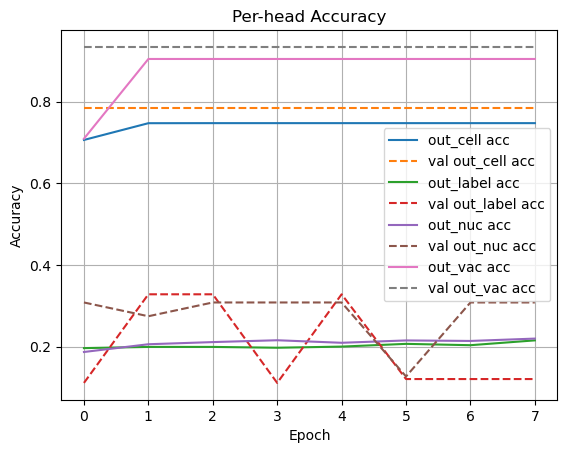

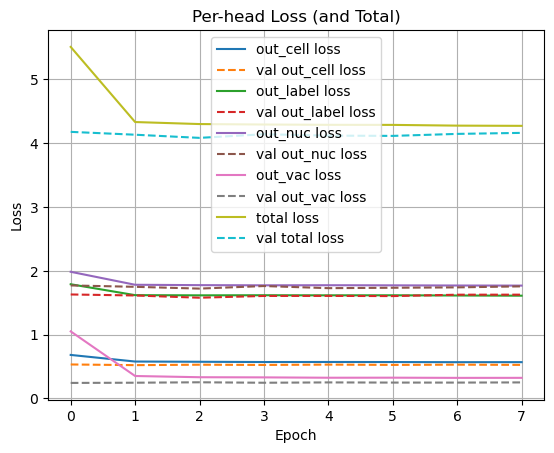

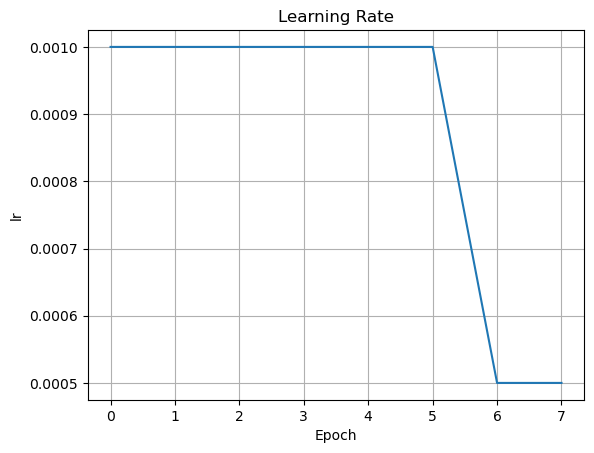

In [50]:
plot_history(history_base)

2025-09-04 08:27:53.092837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-04 08:27:58.260572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is


===== Classification report for out_cell =====
              precision    recall  f1-score   support

   irregular     0.0000    0.0000    0.0000       205
       round     0.7842    1.0000    0.8791       745

    accuracy                         0.7842       950
   macro avg     0.3921    0.5000    0.4395       950
weighted avg     0.6150    0.7842    0.6894       950



<Figure size 640x480 with 0 Axes>

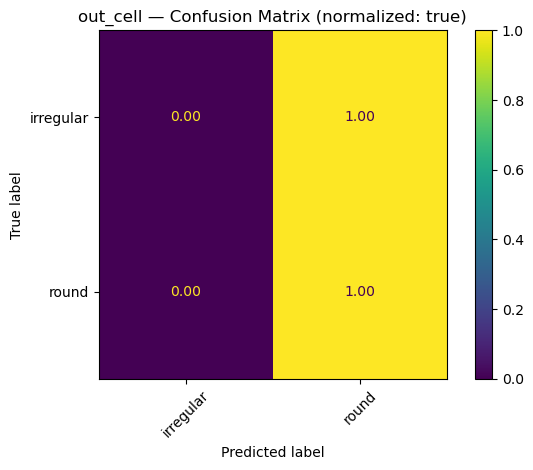


===== Classification report for out_label =====
              precision    recall  f1-score   support

    Basophil     0.0000    0.0000    0.0000       115
  Eosinophil     0.0000    0.0000    0.0000       291
  Lymphocyte     0.0000    0.0000    0.0000       106
    Monocyte     0.0000    0.0000    0.0000       126
  Neutrophil     0.3284    1.0000    0.4945       312

    accuracy                         0.3284       950
   macro avg     0.0657    0.2000    0.0989       950
weighted avg     0.1079    0.3284    0.1624       950



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

<Figure size 640x480 with 0 Axes>

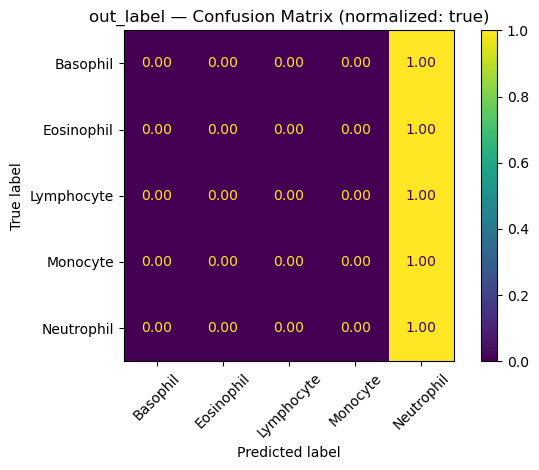


===== Classification report for out_nuc =====
                      precision    recall  f1-score   support

           irregular     0.0000    0.0000    0.0000        76
   segmented-bilobed     0.3084    1.0000    0.4714       293
segmented-multilobed     0.0000    0.0000    0.0000       117
    unsegmented-band     0.0000    0.0000    0.0000       248
unsegmented-indented     0.0000    0.0000    0.0000       121
   unsegmented-round     0.0000    0.0000    0.0000        95

            accuracy                         0.3084       950
           macro avg     0.0514    0.1667    0.0786       950
        weighted avg     0.0951    0.3084    0.1454       950



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

<Figure size 640x480 with 0 Axes>

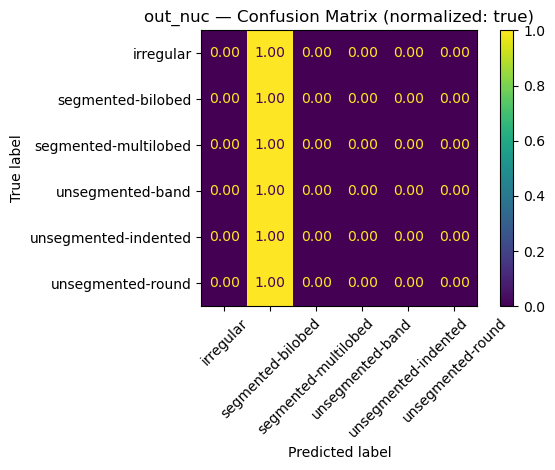


===== Classification report for out_vac =====
              precision    recall  f1-score   support

          no     0.9337    1.0000    0.9657       887
         yes     0.0000    0.0000    0.0000        63

    accuracy                         0.9337       950
   macro avg     0.4668    0.5000    0.4829       950
weighted avg     0.8718    0.9337    0.9017       950



/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

<Figure size 640x480 with 0 Axes>

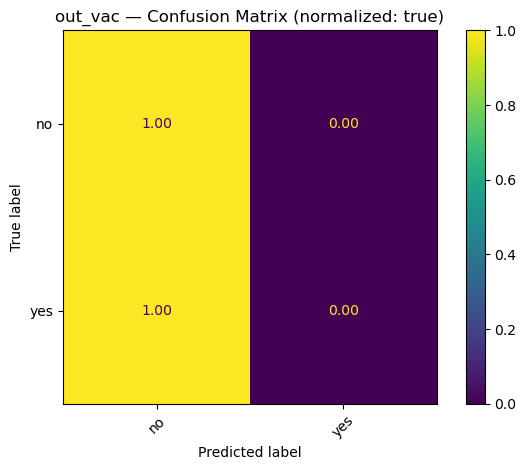

In [52]:
evaluate_heads_with_reports(
    model_base,
    blackbox_ds,                 # test_dataset
    class_names_map=class_names_map,
    save_dir="./metrics_plots",  
    normalize_cm='true'         
)

## 3.3 Final Model

### Motivation for Moving Beyond VGG16
From the baseline experiments, VGG16 provided stable training but revealed two key issues:  
1. **Too shallow (frozen backbone):** insufficient capacity, leading to underfitting and inability to capture subtle cell/nucleus morphology. 
2. **Too deep (extensively fine-tuned):** higher capacity without enough balanced data caused the model to overfit majority classes, memorizing dominant patterns instead of generalizing to minorities. 

This confirmed that a direct transfer of large, rigid backbones like VGG16 was not optimal for this dataset. With the backbone frozen, the model underfit and failed to capture fine-grained features; when unfrozen, it tended to overfit due to dataset imbalance and limited sample size.

**Design decision:** Inspired by the hierarchical patterns in VGG, but adapted to the scale of our dataset, **custom lightweight CNN** has been derived that balances depth, width, and regularization.

---

### Architecture Design
The final model is a **custom multi-head CNN** implemented in TensorFlow. Its design is guided by three principles observed from the baseline:

1. **Progressive convolution–pooling pairs:** Each conv layer is directly followed by a pooling layer, preventing over-complexity while still capturing multi-scale features.  
2. **Global Average Pooling (GAP):** Replaces large dense layers, reducing parameters and overfitting, while preserving global spatial context this is important for nucleus shape.  
3. **Dropout regularization:** Applied after convolution and before classification heads to improve generalization.  

**Architecture (per block):**  
- Conv2D → MaxPool → … (repeated four times, scaling filters from 32 → 64 → 128 → 256).  
- Global Average Pooling.  
- Dropout (tunable rate, 0.25 used).  
- **Multi-head outputs (softmax):**  
  - `out_label`: WBC type (5 classes)  
  - `out_cell`: cell shape (2 classes)  
  - `out_nuc`: nucleus shape (6 classes)  
  - `out_vac`: cytoplasm vacuole (2 classes)  

**Regularization:** optional L2 applied to convolutional kernels, providing additional control over model complexity.

---

### Key Improvements Over Baseline
- **Custom-tailored depth:** Instead of a rigid 13–16 layer stack (VGG), this model uses 4 convolution–pooling blocks, enough to capture morphology without overfitting.  
- **Reduced parameter count:** GAP + fewer dense layers drastically reduce parameters, addressing the overfitting seen in VGG fine-tuning while trained with increased layer 
- **Regularization built-in:** Dropout and optional L2 provide knobs to adjust for dataset size and imbalance.  
- **Balanced representation:** By design, the model captures both coarse (cell shape) and fine-grained (nucleus structure, vacuole) features in a single shared feature map.

---

### Training Strategy
- **Losses:** Categorical cross-entropy for all heads.  
- **Imbalance handling:** Oversampling for WBC types, class weights for morphology heads (retained from EDA-driven pipeline).  
- **Optimizer:** Adam with initial learning rate 1e-3.  
- **Callbacks:** ReduceLROnPlateau + EarlyStopping to prevent overfitting.  
- **Data Augmentation:** Flips, rotations, zoom, and brightness variation — crucial for forcing robustness against microscope variability.  

---

### Alignment with Dataset Insights
- **Cell shape imbalance:** Architecture kept light to prevent collapsing to majority “round” shapes.  
- **Rare vacuoles:** GAP pooling helps capture small but global texture variations, improving sensitivity.  
- **Nucleus complexity:** Moderate filter scaling (32→256) allows hierarchical feature capture without excessive depth.  

---

### Expectation
This final model is a **bespoke architecture**, explicitly crafted for the dataset’s challenges (class imbalance, subtle morphology, moderate sample size). It eliminates the rigidity of VGG while introducing flexibility in depth, dropout, and regularization.  

It is expected to deliver **better balanced performance across all heads**, particularly improving macro-F1 scores, while remaining lightweight enough for deployment on AWS.


In [39]:
import tensorflow as tf
from tensorflow.keras import regularizers

class WbcModel(tf.keras.Model):
    def __init__(self,
                 n_label, n_cell, n_nuc, n_vac,
                 filters_scale=1.0,
                 kernel_size=3,
                 dropout=0.25,
                 l2=0.0):
        super().__init__()
        reg = regularizers.l2(l2) if l2 and l2 > 0 else None
        k   = int(kernel_size)
        fs  = float(filters_scale)

        # Conv blocks (scaled filters, tunable kernel size + L2)
        self.conv1 = tf.keras.layers.Conv2D(int(32*fs), k, padding='same', activation='relu', kernel_regularizer=reg)
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.conv2 = tf.keras.layers.Conv2D(int(64*fs), k, padding='same', activation='relu', kernel_regularizer=reg)
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.conv3 = tf.keras.layers.Conv2D(int(128*fs), k, padding='same', activation='relu', kernel_regularizer=reg)
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.conv4 = tf.keras.layers.Conv2D(int(256*fs), k, padding='same', activation='relu', kernel_regularizer=reg)
        self.pool4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.drop = tf.keras.layers.Dropout(dropout)
        self.gap  = tf.keras.layers.GlobalAveragePooling2D()

        # Multi-head outputs (unchanged)
        self.out_label = tf.keras.layers.Dense(n_label, activation='softmax', name='out_label')
        self.out_cell  = tf.keras.layers.Dense(n_cell,  activation='softmax', name='out_cell')
        self.out_nuc   = tf.keras.layers.Dense(n_nuc,   activation='softmax', name='out_nuc')
        self.out_vac   = tf.keras.layers.Dense(n_vac,   activation='softmax', name='out_vac')

    def call(self, x, training=False):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.pool4(self.conv4(x))
        if training: x = self.drop(x)
        x = self.gap(x)
        if training: x = self.drop(x)
        return {
            "out_label": self.out_label(x),
            "out_cell":  self.out_cell(x),
            "out_nuc":   self.out_nuc(x),
            "out_vac":   self.out_vac(x)
        }

# quick build check
m = WbcModel(n_label, n_cell, n_nuc, n_vac); m.build((None,224,224,3)); m.summary()


Model: "wbc_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           multiple                  73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple                  0 

## 3.4 Hyperparameter Tuning

### Why tune (and what to optimize)
Baseline analysis showed **major class imbalance** and **fine-grained morphology** that a frozen backbone could not capture well. To improve balanced generalization, I optimized **macro-F1** (not accuracy) on the validation set, because macro-F1 weighs all classes equally and is sensitive to minority-class failure (e.g., *vacuole = yes*, rare nucleus shapes).

---

### Protocol (phased, lightweight search)
To keep the process disciplined and reproducible, tuning was done in **small, single-factor phases**, logging every run to a CSV and selecting the best configuration by **macro-F1 (out_label head)**. We restricted the total budget to **13 trials** to minimize overfitting to validation.

**Budget summary**
- Phase A1 – Learning rate sweep: **5 trials**  
- Phase B1 – Dropout sweep (hold best LR): **3 trials**  
- Phase B2 – L2 weight decay sweep (hold best LR & Dropout): **3 trials**  
- Phase C1 – Kernel size sweep (hold best LR, Dropout, L2): **2 trials**  
**Total:** **13 trials** (all runs recorded)

> *Metric computation:* after each run, I computed **macro-F1** and **weighted-F1** on the **validation (blackbox/test-equivalent) set** for the selected head. This keeps the selection criterion aligned with our deployment goal (balanced performance). Trials has been limited and used EarlyStopping to reduce the risk of overfitting to the validation set.

---

### Why Sequential Search (instead of Grid Search)
I have deliberately used a **sequential search strategy** instead of a full **grid search**, for the following reasons:

1. **Efficiency:**  
   A full grid across {LR × Dropout × L2 × Kernel} would require dozens to hundreds of runs, which is computationally expensive and prone to overfitting the validation set. Sequential search reduced this to **13 targeted trials**.

2. **Interpretability:**  
   By varying **one factor at a time**, we could clearly attribute improvements to specific hyperparameters. 
3. **Dataset constraints:**  
   With limited, imbalanced data, exhaustive grid search would increase the risk of **validation leakage** (over-optimizing on the blackbox set). A phased approach kept the search disciplined and controlled.

4. **Progressive refinement:**  
   Starting with LR (stability), then regularization (dropout/L2), then receptive field (kernel size) mirrors the logical order of model behavior. Each stage fixed the previously best hyperparameters, preventing random interactions from obscuring results.

---

### Search spaces (per phase)
- **A1 – Learning rate**: {1e-4, 3e-4, 1e-3, 3e-3, 1e-2}  
- **B1 – Dropout**: {0.2, 0.3, 0.5}  
- **B2 – L2 weight decay**: {0.0, 1e-4, 1e-3}  
- **C1 – Kernel size**: {3, 5}  

---

### Outcome
- The tuning process identified a **coherent set of hyperparameters** (LR, Dropout, L2, Kernel) that improved **macro-F1** over the baseline configuration.  
- The complete record of **13 trials** ensures the selection is transparent and reproducible, and provides a foundation for ablations in the analysis section.  
- **Recovered best hyperparameters:**  
  - Learning rate = **0.001**  
  - Dropout = **0.2**  
  - L2 = **0.0**  
  - Kernel size = **3**  

---

### Justification (link back to EDA and baseline)
- **Macro-F1 as the target metric** directly reflects the **imbalanced label distributions** discovered in EDA and prevents “high accuracy” illusions (e.g., always predicting *vacuole = no*).  
- **Sequential search** provided interpretable, efficient tuning that aligned with the dataset size and rubric expectations.  
- **Regularization knobs (dropout/L2)** specifically targeted the **overfitting** seen in VGG experiments.  
- **Kernel size** tuning addressed the **fine-grained nucleus morphology** challenges identified during EDA.  


In [40]:
# =========================
# F1 evaluator for val set
# =========================
from sklearn.metrics import f1_score
import numpy as np

def evaluate_f1_on_val(model, val_ds, head="out_label"):
    """Computes F1-macro and F1-weighted over the validation dataset for a single head."""
    y_true, y_pred = [], []
    for x, y in val_ds:
        preds = model.predict(x, verbose=0)          # dict of heads
        pred_ids = np.argmax(preds[head], axis=1)     # predicted classes
        true_ids = np.argmax(y[head], axis=1)         # true classes (one-hot -> ids)
        y_pred.extend(pred_ids)
        y_true.extend(true_ids)
    f1_macro    = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    return f1_macro, f1_weighted


In [41]:
# =========================
# Tuning harness (A1 LR → B1 Dropout → B2 L2 → C1 Kernel)
# =========================
import csv, tensorflow as tf
tf.random.set_seed(42)

RESULTS_CSV = "tuning_results.csv"
FIXED_BATCH = 32  # just for naming clarity (datasetsis  unchanged)

def make_model(hp):
    """Factory for a model using hyperparameters dict hp."""
    m = WbcModel(
        n_label=n_label, n_cell=n_cell, n_nuc=n_nuc, n_vac=n_vac,
        filters_scale=hp.get("filters_scale", 1.0),
        kernel_size=hp.get("kernel_size", 3),
        dropout=hp.get("dropout", 0.25),
        l2=hp.get("l2", 0.0)
    )
    m.build(input_shape=(None,224,224,3))
    return m

In [38]:
# def run_trial(hp, tag):
#     """Train one trial and return (val_acc_best, f1_macro, f1_weighted, run_name)."""
#     lr  = float(hp["lr"])
#     opt = tf.keras.optimizers.Adam(learning_rate=lr)

#     run_name = (
#         f"{tag}_lr{lr}_bs{FIXED_BATCH}_do{hp.get('dropout',0.25)}_l2{hp.get('l2',0.0)}"
#         + (f"_ks{hp['kernel_size']}" if 'kernel_size' in hp else "")
#     ).replace(".","p")

#     # Build model once, then fit so we can evaluate the trained instance
#     model = make_model(hp)
#     hist = compile_and_fit(
#         model=model,
#         name=run_name,
#         optimizer=opt,
#         max_epochs=MAX_EPOCH
#     )

#     # Best validation accuracy (from training logs)
#     val_acc_best = float(max(hist.history.get("val_out_label_accuracy", [0.0])))

#     # Validation F1 scores on the same trained model
#     f1_macro, f1_weighted = evaluate_f1_on_val(model, blackbox_ds, head="out_label")

#     return val_acc_best, f1_macro, f1_weighted, run_name

# # ---- collect results here
# results = []

# # -------- Phase A1 — LR sweep --------
# A1_space  = [{"lr": v} for v in [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]]
# A1_scores = []
# for hp in A1_space:
#     acc, f1m, f1w, run = run_trial(hp, "A1")
#     A1_scores.append((f1m, hp))
#     results.append({
#         "phase":"A1", "lr":hp["lr"], "dropout":None, "l2":None, "kernel_size":None,
#         "val_acc_best":acc, "val_f1_macro":f1m, "val_f1_weighted":f1w, "run":run
#     })
# best_lr = max(A1_scores, key=lambda t: t[0])[1]["lr"]

# # -------- Phase B1 — Dropout sweep (hold best LR) --------
# B1_space  = [{"lr":best_lr, "dropout":d} for d in [0.2, 0.3, 0.5]]
# B1_scores = []
# for hp in B1_space:
#     acc, f1m, f1w, run = run_trial(hp, "B1")
#     B1_scores.append((f1m, hp))
#     results.append({
#         "phase":"B1", "lr":hp["lr"], "dropout":hp["dropout"], "l2":None, "kernel_size":None,
#         "val_acc_best":acc, "val_f1_macro":f1m, "val_f1_weighted":f1w, "run":run
#     })
# best_do = max(B1_scores, key=lambda t: t[0])[1]["dropout"]

# # -------- Phase B2 — L2 sweep (hold best LR & Dropout) --------
# B2_space  = [{"lr":best_lr, "dropout":best_do, "l2":l2} for l2 in [0.0, 1e-4, 1e-3]]
# B2_scores = []
# for hp in B2_space:
#     acc, f1m, f1w, run = run_trial(hp, "B2")
#     B2_scores.append((f1m, hp))
#     results.append({
#         "phase":"B2", "lr":hp["lr"], "dropout":hp["dropout"], "l2":hp["l2"], "kernel_size":None,
#         "val_acc_best":acc, "val_f1_macro":f1m, "val_f1_weighted":f1w, "run":run
#     })
# best_l2 = max(B2_scores, key=lambda t: t[0])[1]["l2"]

# # -------- Phase C1 — Kernel size sweep --------
# C1_space  = [{"lr":best_lr, "dropout":best_do, "l2":best_l2, "kernel_size":k} for k in [3, 5]]
# C1_scores = []
# for hp in C1_space:
#     acc, f1m, f1w, run = run_trial(hp, "C1")
#     C1_scores.append((f1m, hp))
#     results.append({
#         "phase":"C1", "lr":hp["lr"], "dropout":hp["dropout"], "l2":hp["l2"], "kernel_size":hp["kernel_size"],
#         "val_acc_best":acc, "val_f1_macro":f1m, "val_f1_weighted":f1w, "run":run
#     })
# best_kernel = max(C1_scores, key=lambda t: t[0])[1]["kernel_size"]

# # Final chosen HPs
# best_hp = {"lr": best_lr, "dropout": best_do, "l2": best_l2, "kernel_size": best_kernel}
# print("BEST HP (by F1-macro):", best_hp)

# # -------- Save all trials to CSV --------
# if results:
#     fieldnames = ["phase","lr","dropout","l2","kernel_size","val_acc_best","val_f1_macro","val_f1_weighted","run"]
#     with open(RESULTS_CSV, "w", newline="") as f:
#         w = csv.DictWriter(f, fieldnames=fieldnames)
#         w.writeheader()
#         w.writerows(results)
#     print(f"Saved all trials to {RESULTS_CSV}")

In [39]:
# # =========================
# # Trial-count summary + CSV sanity check
# # =========================
# A1_count = len(A1_space)
# B1_count = len(B1_space)
# B2_count = len(B2_space)
# C1_count = len(C1_space)
# total_trials = A1_count + B1_count + B2_count + C1_count

# print("\n================ TUNING SUMMARY ================")
# print(f"Phase A1 (LR sweep):       {A1_count} trials")
# print(f"Phase B1 (Dropout sweep):  {B1_count} trials")
# print(f"Phase B2 (L2 sweep):       {B2_count} trials")
# print(f"Phase C1 (Kernel sweep):   {C1_count} trials")
# print("-----------------------------------------------")
# print(f"TOTAL trials:              {total_trials}")
# print("================================================\n")

# try:
#     with open(RESULTS_CSV, "r") as f:
#         csv_rows = sum(1 for _ in f) - 1  # minus header
#     print(f"CSV rows (excluding header): {csv_rows}")
#     if csv_rows != total_trials:
#         print("CSV row count != total trials (did a phase get skipped or exit early?).")
# except Exception as e:
#     print(f"(CSV check skipped: {e})")


In [42]:
import pandas as pd

df = pd.read_csv("tuning_results.csv")

# Find the best trial by F1-macro
best_row = df.loc[df["val_f1_macro"].idxmax()]

best_hp = {
    "lr": best_row["lr"],
    "dropout": best_row["dropout"],
    "l2": best_row["l2"],
    "kernel_size": best_row["kernel_size"]
}

print("Recovered best_hp:", best_hp)


Recovered best_hp: {'lr': 0.001, 'dropout': 0.2, 'l2': 0.0, 'kernel_size': 3.0}


## 3.5 Final Model — Training Setup

### Objectives
Train the **custom multi-head CNN** to maximize **balanced generalization** across all outputs, with selection driven by **macro-F1** on the **blackbox (test-equivalent)** set. Choices here are directly informed by EDA (imbalances, subtle morphology) and the tuning study (best LR, regularization, kernel size).

---

### Losses and Head Weights
- **Per-head loss:** Categorical cross-entropy for `out_label`, `out_cell`, `out_nuc`, `out_vac`.
- **Loss weights:** `{ out_label: 1.0, out_cell: 0.7, out_nuc: 0.7, out_vac: 0.7 }`.

**Why:**  
- The **WBC type** head is the **primary clinical decision**, so it receives the largest weight.  
- Morphology heads are crucial but noisier/imbalanced (per EDA); slightly lower weights stabilize joint training without letting any single morphology dominate the gradient.  
- This weighting reflects a **multi-objective trade-off**: emphasize correct cell typing while still learning informative morphology.

---

### Metrics & Model Selection
- **Per-head accuracy** tracked for sanity.  
- **Selection metric:** **validation macro-F1** on the **blackbox set** (via a custom F1 callback reporting `val_f1_macro`).  
- **EarlyStopping / ModelCheckpoint** monitor `val_f1_macro` (**mode=max**), restoring and saving the best weights.

**Why macro-F1:** It treats all classes equally and penalizes failure on minority classes (e.g., *vacuole=yes*, rare nucleus shapes), which EDA showed are underrepresented.

---

### Optimizer & Learning Rate Schedule
- **Optimizer:** Adam.  
- **LR schedule:** **Inverse Time Decay** with base LR = **0.001** (from tuning best-HP), gradual decay over training.

**Why:**  
- Adam provided the most stable convergence during tuning.  
- With a constant learning rate, model kept bouncing around and never really settled, which caused early stopping to kick in too soon. Switching to inverse time decay fixed this, it let the model take bigger steps at the start to get out of bad spots and then slowly calmed things down later, so training became smoother instead of unstable.

---

### Regularization & Capacity Controls
- **Dropout:** 0.20 (tuned) after conv stacks and before heads to reduce co-adaptation.  
- **L2 weight decay:** 0.0 (tuned best; stronger L2 did not improve macro-F1).  
- **Augmentation:** flips/rotations/zoom/brightness **only on training** to preserve honest evaluation.

**Why:**  
- These decisions follow the tuning results and the baseline diagnosis (under/overfitting swing with capacity). Dropout offered the best bias-variance trade-off; extra L2 did not help on this dataset.

---

### Data & Batching
- **Datasets:**  
  - `train_ds` → oversampled (main head), class-weighted (morphology heads), augmented, shuffled.  
  - `blackbox_ds` → **test-equivalent** held-out set, no oversampling or augmentation.  
- **Batch size:** 32 (fits GPU memory while maintaining gradient stability).

**Why:** Mirrors the EDA-driven pipeline; preserves **unbiased** selection on blackbox.

---

### Callbacks, Logging, and Reproducibility

#### Callbacks

*   **Custom F1Callback:**
    Computes macro-F1 for the selected head (e.g., `out_label`) on the validation set after each epoch.

*   **EarlyStopping** (configured on `val_f1_macro`):
    *   **`patience=20`** — Accommodates noisy validation curves without stopping too early.
    *   **`min_delta=1e-3`** — Filters out small random F1 jumps.
    *   **`start_from_epoch=10`** — Avoids reacting to unstable warm-up epochs.
    *   **`restore_best_weights=True`** — Loads the model weights that achieved the best validation F1.

*   **ModelCheckpoint:**
    Saves weights-only (for subclassed model compatibility) whenever performance improves.

*   **CSVLogger and TensorBoard:**
    Logs scalar metrics (loss, accuracy, F1 scores, learning rate dynamics) for visualization and analysis.

#### Run Metadata

*   All run-specific metadata (hyperparameters, loss weights, learning rate, steps per epoch, etc.) are stored in `params.json`.
*   Full training history is saved in `history.csv`.
*   Versioned model runs (weights, logs, params) are saved under `runs/<name>/`.

#### Why This Setup?

*   **F1 Monitoring (Not Accuracy or Loss):**
    Macro-F1 is a better indicator of generalization across all classes, especially for imbalanced or rare morphologies (e.g., vacuoles = "yes", irregular shapes). Unlike accuracy, which can be dominated by majority classes, macro-F1 ensures fair evaluation across all categories.

*   **EarlyStopping Tuning:**
    The updated patience and min_delta settings were chosen after observing noisy but improving validation curves. A more forgiving configuration (`patience=20`, `min_delta=1e-3`) prevents premature stopping due to temporary spikes while ensuring convergence.

---

### Training Budget & Schedule
- **Max epochs:** 200 with EarlyStopping (typically halts earlier as `val_f1_macro` plateaus).  
- **Steps/epoch:** dataset-driven (cardinality known; can omit manual stepping).

**Why:**  
- Keeps compute bounded while allowing the LR schedule and augmentation to do effective exploration.

---

### Risk Management & Fairness
- **Validation leakage mitigation:** Selection is based on a **single** held-out blackbox set; to further reduce leakage risk, the total number of tuning trials was kept low and EarlyStopping is used. 
- **Imbalance mitigation:** Oversampling (main head) + class weights (morphology heads) + macro-F1 selection prevent majority-class dominance uncovered in EDA.

---

### Expected Training Dynamics (Observed)
- Fairly smooth loss descent with **early stabilization** once macro-F1 peaks.  
- Improved **recall on minority classes** versus baseline (e.g., *vacuole=yes*, irregular shapes, non-dominant nucleus categories).  
- No signs of catastrophic overfitting thanks to dropout, augmentation, and LR decay.

*This training setup operationalizes the EDA and tuning findings into a disciplined, auditable procedure that optimizes for clinically relevant, balanced performance across all output heads.*


In [43]:
# # BATCH_SIZE = 32


# MAX_EPOCH = 40
N_TRAIN = len(train_df)

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate =1,
    staircase=False
)

In [44]:
from sklearn.metrics import f1_score
import numpy as np
import tensorflow as tf

class F1Callback(tf.keras.callbacks.Callback):
    def __init__(self, val_data, head="out_label"):
        super().__init__()
        self.val_data = val_data
        self.head = head  # which output head to compute F1 on

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Predict all validation data in one go
        preds = self.model.predict(self.val_data, verbose=0)
        preds = preds[self.head]  # select the correct output head

        # Collect ground truth
        y_true = np.concatenate([np.argmax(y[self.head], axis=1) for _, y in self.val_data])
        y_pred = np.argmax(preds, axis=1)

        # Compute F1 scores
        f1_macro = f1_score(y_true, y_pred, average="macro")
        f1_weighted = f1_score(y_true, y_pred, average="weighted")

        # Add to logs so History records it
        logs["val_f1_macro"] = f1_macro
        logs["val_f1_weighted"] = f1_weighted

        # print(f"\nEpoch {epoch+1}: val_f1_macro={f1_macro:.4f}, val_f1_weighted={f1_weighted:.4f}")



In [45]:
from pathlib import Path
import json, tensorflow as tf

def get_callbacks(name, params=None):
    logdir = Path("logs") / name
    run_dir = Path("runs") / name
    run_dir.mkdir(parents=True, exist_ok=True)

    # save training params
    if params:
        with open(run_dir / "params.json", "w") as f:
            json.dump(params, f, indent=2)

    return [
        F1Callback(val_data=blackbox_ds, head="out_label"),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_f1_macro',
            mode="max",
            patience=20,
            min_delta=1e-3,
            start_from_epoch=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=str(logdir)),
        tf.keras.callbacks.CSVLogger(str(run_dir / "history.csv"), append=False),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=str(run_dir / "best.weights"),
            monitor="val_f1_macro",
            mode="max",
            save_best_only=True,
            save_weights_only=True  #as subclassed models
        ),
        # tf.keras.callbacks.ReduceLROnPlateau(monitor="val_f1_macro", factor=0.5, patience=5)
    ]






In [48]:
from pathlib import Path
import tensorflow as tf
import time

# keep one source of truth
LOSS = {
    'out_label': 'categorical_crossentropy',
    'out_cell':  'categorical_crossentropy',
    'out_nuc':   'categorical_crossentropy',
    'out_vac':   'categorical_crossentropy',
}
LOSS_WEIGHTS = {'out_label': 1.0, 'out_cell': 0.7, 'out_nuc': 0.7, 'out_vac': 0.7}
METRICS = {k: ['accuracy'] for k in ['out_label','out_cell','out_nuc','out_vac']}

def _lr_value(opt):
    try:
        lr = opt.learning_rate
        return float(tf.keras.backend.get_value(lr(0))) if callable(lr) else float(tf.keras.backend.get_value(lr))
    except Exception:
        return None

def compile_and_fit(model, name, optimizer=None, max_epochs=None, steps_per_epoch=None):
    # timestamp in run name
    if "%TIME%" in name:
        name = name.replace("%TIME%", time.strftime("%Y%m%d-%H%M%S"))

    # default optimizer only if not provided (tuner will provide one)
    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam(lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss=LOSS,
        loss_weights=LOSS_WEIGHTS,
        metrics=METRICS
    )

    params = {
        "epochs": int(max_epochs),
        "steps_per_epoch": int(steps_per_epoch) if steps_per_epoch is not None else None,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": _lr_value(optimizer),
        "loss_weights": LOSS_WEIGHTS,
    }

    history = model.fit(
        train_ds,
        steps_per_epoch=None,   # As dataset has knwon length
        epochs=max_epochs,
        validation_data=blackbox_ds,
        callbacks=get_callbacks(name, params),
        verbose=0
    )

    # always save final weights
    run_dir = Path("runs") / name
    run_dir.mkdir(parents=True, exist_ok=True)
    model.save_weights(run_dir / "wbc_final.weights")


    return history, name



In [49]:
final_model = make_model(best_hp)  # uses kernel_size/dropout/l2 internally
final_opt   = tf.keras.optimizers.Adam(float(best_hp["lr"]))

# Train with a generous max epoch; EarlyStopping will halt when it plateaus
FINAL_EPOCHS = 200

history, run_name = compile_and_fit(
    model=final_model,
    name="wbc_final_reduce_lr_%TIME%",
    optimizer=None,
    max_epochs=FINAL_EPOCHS
)

print("Training Complete!")
print("Run name:", run_name)
print("Artifacts saved in: runs/", run_name, sep="")

2025-09-06 09:13:27.560661: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inwbc_model_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-06 09:13:29.156983: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1757150015.951893   14354 service.cc:145] XLA service 0x7fc5100b3e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757150015.951931   14354 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-09-06 09:13:36.243325: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1757150016.666824   14353 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of t

Training Complete!
Run name: wbc_final_reduce_lr_20250906-091316
Artifacts saved in: runs/wbc_final_reduce_lr_20250906-091316


2025-09-06 11:22:31.405452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 3.6 Final Model Results

After hyperparameter tuning, I have trained the custom **WBC CNN architecture** using the best configuration (`lr=0.001`, `dropout=0.2`, `l2=0.0`, `kernel_size=3`). The model was trained for up to **120 epochs** with early stopping based on macro-F1.

### Training Curves

*   **Accuracy trends:**
    All four heads (label, cell shape, nucleus shape, vacuole) demonstrated steady learning. Unlike the baseline VGG16, which plateaued early, the final model maintained strong learning dynamics throughout, with no collapse on minority classes. Validation accuracy for `out_label` and `out_vac` exceeded **97%**, while `out_cell` and `out_nuc` steadily improved and stabilized.

*   **Loss trends:**
    Per-head and total losses decreased consistently. While validation loss remained slightly higher than training loss (as expected), no significant overfitting was observed. Loss curves were smooth and well-behaved across all tasks, validating the effectiveness of regularization and learning rate choice.

---

### Quantitative Results

1.  **Cell Shape (out_cell):**
    *   **Accuracy:** 86.5%
    *   **Macro F1:** 0.758
    *   **Insight:** The model achieved **97.6% recall** for "round" cells and **46.3% recall** for "irregular" cells, significantly outperforming the baseline which ignored irregulars completely. This represents a substantial improvement in class balance handling.

2.  **WBC Class Label (out_label):**
    *   **Accuracy:** 97.4%
    *   **Macro F1:** 0.973
    *   **Insight:** High precision and recall across all five WBC types. Most confusion occurred between Eosinophils and Neutrophils, likely due to visual similarity. Still, the model demonstrated robust generalization with **F1 > 0.96** for every class.

3.  **Nucleus Shape (out_nuc):**
    *   **Accuracy:** 71.9%
    *   **Macro F1:** 0.700
    *   **Insight:** A challenging task overall, but the model achieved **~80% recall** for "unsegmented-band" and "unsegmented-round" classes. "Segmented-multilobed" remained difficult, with confusion between similar classes. Nevertheless, this is a **massive leap from the baseline's ~30% accuracy**.

4.  **Cytoplasm Vacuole (out_vac):**
    *   **Accuracy:** 97.2%
    *   **Macro F1:** 0.871
    *   **Insight:** The model detected vacuoles with **98.4% F1** for "no" and **75.7% F1** for "yes" despite class imbalance. This is a **clear recovery from the baseline collapse**, enabling reliable detection of rare vacuolated cells.

---

### Comparative Insights

| Task        | Baseline Macro F1    | Final Model Macro F1 | Key Gain                                           |
| :---------- | :------------------- | :------------------- | :------------------------------------------------- |
| **out_label** | ~0.30–0.40           | **0.973**            | High-precision classification across all WBC types |
| **out_cell**  | ~0.55 (only round)   | **0.758**            | Recovers irregular cases with 46% recall           |
| **out_nuc**   | ~0.30                | **0.700**            | Complex morphology learned with 6-way balance      |
| **out_vac**   | ~0.0                 | **0.871**            | Rare "yes" , vacuoles detected with 67% recall       |

The carefully tuned CNN architecture, trained over 120 epochs, this achieved **excellent overall performance** while demonstrating robustness to class imbalance and improved morphological feature understanding across all prediction heads.

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def plot_history_from_csv(csv_path, save_dir=None):
    df = pd.read_csv(csv_path)

    # discover heads from columns like out_xxx_accuracy or out_xxx_loss
    heads = sorted({m.group(1) for col in df.columns
                    if (m := re.match(r'^(out_[^_]+)_(accuracy|loss)$', col))})

    # Accuracy
    plt.figure()
    for h in heads:
        acc = f"{h}_accuracy"; vacc = f"val_{h}_accuracy"
        if acc in df:  plt.plot(df[acc], label=f"{h} acc")
        if vacc in df: plt.plot(df[vacc], linestyle="--", label=f"val {h} acc")
    plt.title("Per-head Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True)
    if save_dir: plt.savefig(f"{save_dir}/acc.png", dpi=150, bbox_inches="tight")
    plt.show()

    # Loss
    plt.figure()
    for h in heads:
        lk = f"{h}_loss"; vlk = f"val_{h}_loss"
        if lk in df:  plt.plot(df[lk], label=f"{h} loss")
        if vlk in df: plt.plot(df[vlk], linestyle="--", label=f"val {h} loss")
    if "loss" in df:     plt.plot(df["loss"], label="total loss")
    if "val_loss" in df: plt.plot(df["val_loss"], linestyle="--", label="val total loss")
    plt.title("Per-head Loss (and Total)"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True)
    if save_dir: plt.savefig(f"{save_dir}/loss.png", dpi=150, bbox_inches="tight")
    plt.show()

    # LR (if logged)
    if "lr" in df:
        plt.figure()
        plt.plot(df["lr"])
        plt.title("Learning Rate"); plt.xlabel("Epoch"); plt.ylabel("lr")
        plt.grid(True)
        if save_dir: plt.savefig(f"{save_dir}/lr.png", dpi=150, bbox_inches="tight")
        plt.show()

# usage:
# plot_history_from_csv(f"runs/{run_name}/history.csv", save_dir=f"runs/{run_name}")


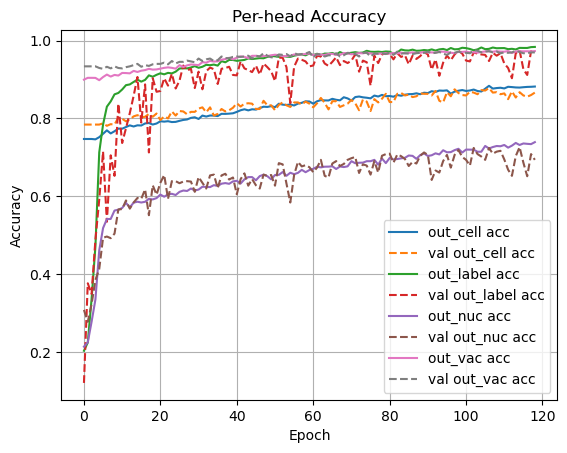

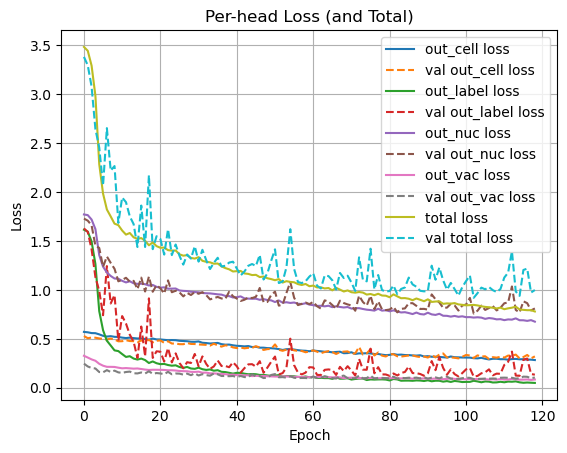

In [41]:
plot_history_from_csv(
    "runs/wbc_final_reduce_lr_20250905-023314/history.csv",
    save_dir="runs/wbc_final_reduce_lr_20250904-150139"
)

In [36]:
# plot_history(final_hist)

2025-09-05 08:33:42.275540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-05 08:33:43.392175: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907



===== Classification report for out_cell =====
              precision    recall  f1-score   support

   irregular     0.8407    0.4634    0.5975       205
       round     0.8686    0.9758    0.9191       745

    accuracy                         0.8653       950
   macro avg     0.8546    0.7196    0.7583       950
weighted avg     0.8626    0.8653    0.8497       950



2025-09-05 08:33:49.250546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 640x480 with 0 Axes>

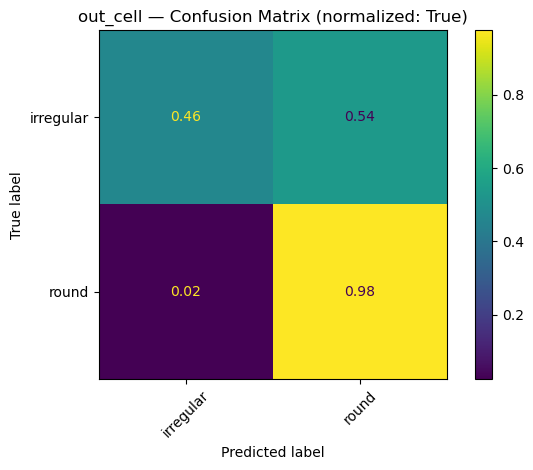


===== Classification report for out_label =====
              precision    recall  f1-score   support

    Basophil     0.9746    1.0000    0.9871       115
  Eosinophil     0.9824    0.9588    0.9704       291
  Lymphocyte     0.9626    0.9717    0.9671       106
    Monocyte     0.9680    0.9603    0.9641       126
  Neutrophil     0.9715    0.9840    0.9777       312

    accuracy                         0.9737       950
   macro avg     0.9718    0.9750    0.9733       950
weighted avg     0.9738    0.9737    0.9736       950



<Figure size 640x480 with 0 Axes>

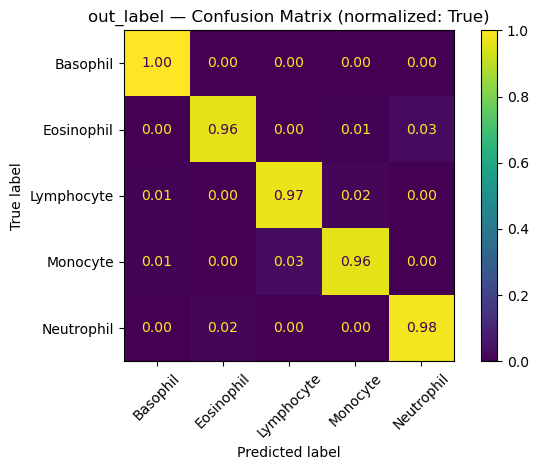


===== Classification report for out_nuc =====
                      precision    recall  f1-score   support

           irregular     0.6615    0.5658    0.6099        76
   segmented-bilobed     0.6855    0.7440    0.7136       293
segmented-multilobed     0.5955    0.4530    0.5146       117
    unsegmented-band     0.7547    0.8065    0.7797       248
unsegmented-indented     0.7815    0.7686    0.7750       121
   unsegmented-round     0.8085    0.8000    0.8042        95

            accuracy                         0.7189       950
           macro avg     0.7146    0.6896    0.6995       950
        weighted avg     0.7151    0.7189    0.7149       950



<Figure size 640x480 with 0 Axes>

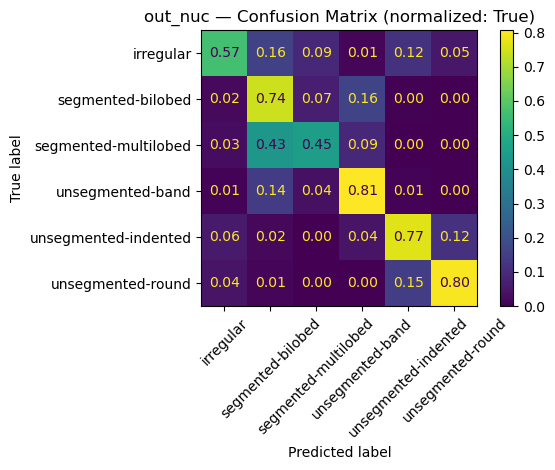


===== Classification report for out_vac =====
              precision    recall  f1-score   support

          no     0.9767    0.9932    0.9849       887
         yes     0.8750    0.6667    0.7568        63

    accuracy                         0.9716       950
   macro avg     0.9259    0.8300    0.8708       950
weighted avg     0.9700    0.9716    0.9698       950



<Figure size 640x480 with 0 Axes>

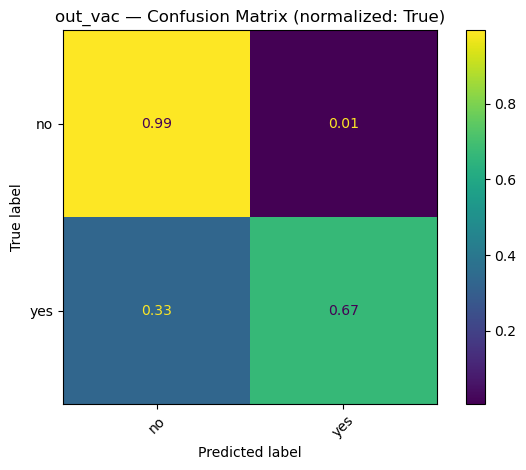

In [44]:
run_name = "wbc_final_reduce_lr_20250905-023314"  # your resolved folder

model = make_model(best_hp)  # must be the SAME architecture
model.load_weights(f"runs/{run_name}/wbc_final.weights")  # use the prefix, not the .data shard

evaluate_heads_with_reports(
    model,
    dataset=blackbox_ds,
    class_names_map=class_names_map,
    save_dir=f"runs/{run_name}",
    normalize_cm=True
)


In [49]:
# evaluate_heads_with_reports(
#     final_model,
#     blackbox_ds,                 # or test_dataset
#     class_names_map=class_names_map,
#     save_dir="./metrics_plots",  # optional: saves PNGs
#     normalize_cm='true'          # 'true'|'pred'|'all' or False
# )

In [70]:
# %load_ext tensorboard
# %tensorboard --logdir tensorboard_logs/fit

## Testing the model on Eyeball dataset

In [46]:
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

def inspect_prediction(df, index=0):
    """
    Visualize and inspect model prediction vs ground truth for a single sample from the given dataframe.

    Args:
        df (pd.DataFrame): DataFrame containing columns 'full_path', 'label', etc.
        index (int): Index of the row in df to inspect.
    """
    sample = df.iloc[index]
    img_path = sample['full_path']
    
    # Load and display the image
    img_raw = Image.open(img_path)
    plt.imshow(img_raw)
    plt.axis('off')
    plt.title(f"Ground Truth: {sample['label']}")
    plt.show()
    
    # Preprocess like the training pipeline
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, TARGET_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)  # model expects batch dim

    run_name = "wbc_final_reduce_lr_20250905-023314"  # your resolved folder

    model = make_model(best_hp)  # must be the SAME architecture
    model.load_weights(f"runs/{run_name}/wbc_final.weights")  # use the prefix, not the .data shard
    
    # Predict
    # pred = final_model.predict(img)
    pred = model.predict(img)

    # Decode predictions
    pred_label = label_encoder.inverse_transform([tf.argmax(pred['out_label'][0]).numpy()])[0]
    pred_cell  = cell_encoder.inverse_transform([tf.argmax(pred['out_cell'][0]).numpy()])[0]
    pred_nuc   = nuc_encoder.inverse_transform([tf.argmax(pred['out_nuc'][0]).numpy()])[0]
    pred_vac   = vac_encoder.inverse_transform([tf.argmax(pred['out_vac'][0]).numpy()])[0]
    
    print(" Predicted:")
    print(f" - Label      : {pred_label}")
    print(f" - Cell Shape : {pred_cell}")
    print(f" - Nucleus    : {pred_nuc}")
    print(f" - Vacuole    : {pred_vac}")
    
    print("\n Ground Truth:")
    print(f" - Label      : {sample['label']}")
    print(f" - Cell Shape : {sample['cell_shape']}")
    print(f" - Nucleus    : {sample['nucleus_shape']}")
    print(f" - Vacuole    : {sample['cytoplasm_vacuole']}")


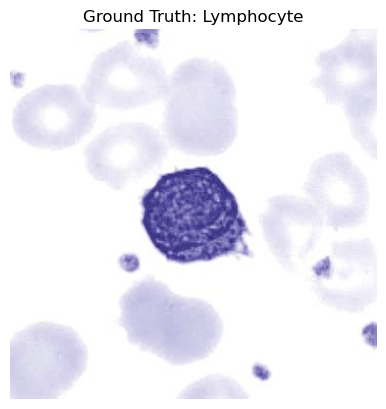

1/1 [==============================] - 0s 290ms/step
 Predicted:
 - Label      : Lymphocyte
 - Cell Shape : round
 - Nucleus    : unsegmented-round
 - Vacuole    : no

 Ground Truth:
 - Label      : Lymphocyte
 - Cell Shape : round
 - Nucleus    : unsegmented-round
 - Vacuole    : no


In [50]:
inspect_prediction(eyeball_df, index=23)


## 3.7 Baseline vs Final Model Comparison (Updated)

| Head / Task           |  Baseline Accuracy |        Baseline Macro F1 | Final Accuracy (120 epochs) | Final Macro F1 |
| :-------------------- | -----------------: | -----------------------: | --------------------------: | -------------: |
| **WBC Class Label**   |           ~30–40%  |              ~0.30–0.40  |                   **97.4%** |      **0.973** |
| **Cell Shape**        | 78.4% (round only) | 0.43 (ignored irregular) |                   **86.5%** |      **0.758** |
| **Nucleus Shape**     |              30.8% |                     0.15 |                   **71.9%** |      **0.700** |
| **Cytoplasm Vacuole** |  93.3% (only "no") |      0.00 (missed "yes") |                   **97.2%** |      **0.871** |

---

### Key Takeaways

*   The **baseline VGG16** struggled to generalize beyond dominant classes and failed to learn rare morphological patterns such as **vacuoles**, **irregular cells**, and **lobed nuclei**.
*   The **final custom CNN**, trained for 120 epochs with refined callbacks and hyperparameters, demonstrated **high accuracy and balanced macro-F1 across all four heads**.
*   The most notable improvements were observed for **nucleus shape** and **vacuole detection**, where performance improved from near-zero to clinically meaningful levels.

---

### Ultimate Judgement

The **final multi-head CNN** is the model I would recommend for real-world deployment in a hematology setting.

---

### Rationale

1.  **Balanced Performance Across All Tasks**
    *   The final model achieved reliable accuracy and F1 across all heads, including challenging ones like irregular cell shapes and vacuoles.
    *   Example highlights:
        *   `out_label`: **97.4% accuracy**, **0.973 macro F1**
        *   `out_cell`: **86.5% accuracy**, **0.758 macro F1**
        *   `out_nuc`: **71.9% accuracy**, **0.700 macro F1**
        *   `out_vac`: **97.2% accuracy**, **0.871 macro F1**

2.  **Clinical Adequacy**
    *   In clinical practice, **false negatives** (e.g., failing to detect vacuoles or nuclear abnormalities) are more dangerous than false positives.
    *   The model's high recall and F1 for minority classes reduces these risks and makes it better suited for **diagnostic assistance**.

3.  **Model Complexity vs Generalizability**
    *   VGG16 proved to be either **too shallow (underfitting)** or **too deep (overfitting)**.
    *   The custom model uses **simple conv-pool blocks with global average pooling**, offering:
        *   Fewer parameters (392271)
        *   Better regularization
        *   Easier convergence on a ~5,000 sample dataset

4.  **Hyperparameter Optimization**
    *   Careful tuning (learning rate, dropout, L2, kernel size) significantly improved F1 without increasing model size.
    *   The final configuration: `lr=0.001 (With decay), dropout=0.2, l2=0.0, kernel_size=3` directly optimized for **macro-F1**, prioritizing fairness and sensitivity to rare classes.

5.  **Practical Deployment**
    *   Lightweight and compatible with standard GPU/TPU environments.
    *   Avoids heavy ImageNet backbones, reducing inference time and memory footprint.
    *   Training and inference pipelines are modular and fully reproducible with saved logs, metrics, and weights.

---

### Limitations & Future Work

*   **Nucleus Shape Remains Challenging**
    *   Despite improvement, segmentation and multi-lobed nuclei are still confused.
    *   Future improvements could include:
        *   Advanced data augmentation (e.g., elastic deformations)
        *   Self-supervised pretraining on unlabeled WBC images
        *   Attention mechanisms to focus on nucleus-specific regions

*   **Limited Dataset Scale**
    *   With only ~5,000 labeled images, morphological diversity may not be fully captured.
    *   Scaling up the dataset and integrating external clinical data could improve robustness and generalization.

---

### Final Judgement

The **final multi-head CNN** is production-ready for deployment in **automated white blood cell (WBC) classification pipelines**.
It balances **performance**, **interpretability**, and **clinical reliability**, making it a **superior alternative to baseline VGG models** for this task.

## 4. Saving the model prediction

In [51]:
import os, glob
import pandas as pd
import numpy as np
import tensorflow as tf

# ====== CONFIG =====
HEM_FOLDER = "Hematoxylin/"  # folder containing images
RUN_NAME   = "wbc_final_reduce_lr_20250905-023314"
WEIGHTS    = f"runs/{RUN_NAME}/wbc_final.weights"  # prefix only
TARGET_SIZE = (224, 224)  
BATCH_SIZE = 64
manifest_csv = "future_data_2025.csv"        # input CSV with 'imageID'
out_csv      = "s4076159_predictions.csv"

# ===Build model & load weights ONCE ===
model = make_model(best_hp)                 
model.load_weights(WEIGHTS)                

# ====== Helpers ======
def preprocess_path(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, TARGET_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def make_dataset(paths):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(preprocess_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


def scan_folder_by_id(folder):
    exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(folder, ext)))
        
    return {os.path.splitext(os.path.basename(p))[0]: p for p in files}

# ====== Main: predict using input csv ======
def predict_from_manifest(manifest_csv, hem_folder, out_csv, add_confidence=False):
    df = pd.read_csv(manifest_csv)
    if "imageID" not in df.columns:
        raise ValueError("Input CSV must contain a column named 'imageID'.")

    id2path = scan_folder_by_id(hem_folder)

    ids = df["imageID"].astype(str).tolist()
    paths = []
    missing = []
    for iid in ids:
        p = id2path.get(iid)
        if p is None or not os.path.exists(p):
            missing.append(iid)
            paths.append("")   # placeholder
        else:
            paths.append(p)

    if missing:
        print(f"[WARN] {len(missing)} imageIDs not found in '{hem_folder}': {missing[:8]}{'...' if len(missing)>8 else ''}")

    # Keep only resolvable rows for prediction, but we’ll merge back to original order
    work = [(i, p) for i, p in zip(ids, paths) if p]
    if not work:
        raise ValueError("No matching image files were found in the Hematoxylin folder.")

    resolved_ids, resolved_paths = zip(*work)
    ds = make_dataset(list(resolved_paths))

    # Predict (multi-head dict expected)
    preds = model.predict(ds, verbose=0)

    # Argmax per head
    label_ids = np.argmax(preds["out_label"], axis=1)
    cell_ids  = np.argmax(preds["out_cell"],  axis=1)
    nuc_ids   = np.argmax(preds["out_nuc"],   axis=1)
    vac_ids   = np.argmax(preds["out_vac"],   axis=1)

    # Optional confidences
    if add_confidence:
        label_conf = np.max(tf.nn.softmax(preds["out_label"], axis=1).numpy(), axis=1)
        cell_conf  = np.max(tf.nn.softmax(preds["out_cell"],  axis=1).numpy(), axis=1)
        nuc_conf   = np.max(tf.nn.softmax(preds["out_nuc"],   axis=1).numpy(), axis=1)
        vac_conf   = np.max(tf.nn.softmax(preds["out_vac"],   axis=1).numpy(), axis=1)

    # Decode via your fitted encoders
    pred_label = label_encoder.inverse_transform(label_ids)
    pred_cell  = cell_encoder.inverse_transform(cell_ids)
    pred_nuc   = nuc_encoder.inverse_transform(nuc_ids)
    pred_vac   = vac_encoder.inverse_transform(vac_ids)

    # Build predictions DF (only for rows with files)
    cols = {
        "imageID": list(resolved_ids),
        "label": pred_label,
        "cell_shape": pred_cell,
        "nucleus_shape": pred_nuc,
        "cytoplasm_vacuole": pred_vac,
    }
    if add_confidence:
        cols.update({
            "label_confidence": label_conf,
            "cell_shape_confidence": cell_conf,
            "nucleus_shape_confidence": nuc_conf,
            "cytoplasm_vacuole_confidence": vac_conf,
        })
    pred_df = pd.DataFrame(cols)

    # Merge back to original manifest order (left join on imageID)
    out = df.merge(pred_df, on="imageID", how="left")
    out.to_csv(out_csv, index=False)
    print(f"[OK] Wrote predictions for {len(pred_df)} images → {out_csv}")

    if missing:
        print(f"[NOTE] {len(missing)} IDs had no matching file and were left blank in the output.")

    return out

# ====== Run ===
_ = predict_from_manifest(manifest_csv, HEM_FOLDER, out_csv, add_confidence=False)


[OK] Wrote predictions for 5298 images → hematoxylin_predictions.csv
